<a href="https://colab.research.google.com/github/NavyaPadamuttam/Loan/blob/main/dlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.python.ops.math_ops import reduce_prod
# The TextVectorization class has been moved to tensorflow.keras.layers
from tensorflow.keras.layers import TextVectorization #changed import to import from keras.layers
from tensorflow.keras.layers import Embedding # Import Embedding from tensorflow.keras.layers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
jobs_file = tf.keras.utils.get_file(
    fname="fraudulent_jobs.csv",  # Removed the path from fname
    origin="https://uofi.box.com/shared/static/sfw0eqvj7q49vmexpztqke7xzhspevnb.csv",
    cache_dir="." # added cache_dir to specify download location
)

df=pd.read_csv(jobs_file)

df.head()

50061601/50061601 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
#drop jobs_id column and update 'work_remote' to 'work_remote's
df.drop(columns=['job_id'], inplace=True)
df.rename(columns={'telecommuting': 'work_remote'}, inplace=True)
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'work_remote',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

Exploring the dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   work_remote          17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [ ]:
df.nunique() #get # of unique values in dataset

,0
title,11231
location,3105
department,1337
salary_range,874
company_profile,1709
description,14801
requirements,11967
benefits,6204
work_remote,2
has_company_logo,2


In [6]:
df.isna().sum()


,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


In [ ]:
df['fraudulent'].value_counts()
#data is very imbalanced

,count
fraudulent,
0,17014
1,866


In [7]:
#separate columns based on their type
text_cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
numeric_cols = ['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high']
col_to_predict = ['fraudulent']


Cleaning Dataset

Text Data

In [10]:
def move_column(df, col):
  df['Temp_Col'] = df[col]
  df.drop(columns=[col], inplace=True)
  df.rename(columns={'Temp_Col': col}, inplace=True)
  return df

In [11]:
df['employment_type'].fillna('No Data', inplace=True)
df['required_experience'].fillna('No Data', inplace=True)
df['required_education'].fillna('No Data', inplace=True)
df['industry'].fillna('No Data', inplace=True)
df['function'].fillna('No Data', inplace=True)

In [12]:
df.isna().sum()

,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


Cleaning dataset
Text Data

In [13]:
def move_column(df, col):
  df['Temp_Col'] = df[col]
  df.drop(columns=[col], inplace=True)
  df.rename(columns={'Temp_Col': col}, inplace=True)
  return df

In [14]:
df['employment_type'].fillna('No Data', inplace=True)
df['required_experience'].fillna('No Data', inplace=True)
df['required_education'].fillna('No Data', inplace=True)
df['industry'].fillna('No Data', inplace=True)
df['function'].fillna('No Data', inplace=True)

In [ ]:
df.isna().sum()


,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
work_remote,0
has_company_logo,0


In [ ]:
df.notna().sum()

,0
job_id,17880
title,17880
location,17534
department,6333
salary_range,2868
company_profile,14572
description,17879
requirements,15184
benefits,10668
telecommuting,17880


In [ ]:
df[df['description'].isna()] #only 1 row with an empty description -- the post only has title and location and it is a fraud post --> keeping it


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17513,17514,Office Manager,"PL, MZ, Warsaw",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,No Data,No Data,No Data,No Data,No Data,1


In [ ]:
#rows that are entirely null in the text columns
null_text = df[(df['location'].isna()) & (df['department'].isna()) & (df['company_profile'].isna()) & (df['requirements'].isna()) & (df['benefits'].isna())]
# 'title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'
print(f"There are {null_text.shape[0]} rows where all text columns aside from 'title' and 'description' are empty. Of these rows, {null_text['fraudulent'].sum()} are fraudulent posts.")


There are 19 rows where all text columns aside from 'title' and 'description' are empty. Of these rows, 12 are fraudulent posts.


In [ ]:
text_cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'] #remove full_text
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
numeric_cols = ['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high']
col_to_predict = ['fraudulent']

In [ ]:
#combine all text into 1 column - full_text
df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits']
df['full_text'][0]

nan

In [ ]:
print(f"Min length of 'full text': {df['full_text'].astype(str).map(len).min()}")
print(f"Max length of 'full text': {df['full_text'].astype(str).map(len).max()}")

Min length of 'full text': 3
Max length of 'full text': 11862


In [ ]:
def update_text(new_df):
  new_df['full_text'] = new_df['full_text'].str.replace(pat='US', repl='USA', case=True)
  new_df['location'] = new_df['location'].str.replace(pat='US', repl='USA', case=True)
  return new_df

In [ ]:
# update US with USA so it does not get mixed up with the word 'us'
df = update_text(df)

#replace urls, email, phone numbers (contact details) ?? maybe presence/absence could indicate a fake post?
# df['full_text'] = df['full_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', ' ', regex=True).replace(r'#PHONE\S+', '', regex=True).replace(r'#EMAIL\S+', '', regex=True)

In [ ]:
#separate 2 separate words that have been put together (i.e. PinterestLoves -> Pinterest Loves)
def space_words(all_text):
  import re
  # print('start', all_text)
  result = re.sub('(?<=[A-Za-z])(?=[A-Z][a-z])', '~', all_text)
  result = re.split('~', result)
  result = ' '.join(result)
  all_text = result
  # print('end',all_text)
  return all_text


In [ ]:
#combine all text into 1 column - full_text
# Make sure 'full_text' is created and populated before the loop
df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits']

texts = ['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'full_text']

for col in texts:
  # Convert the column to string type before applying space_words
  df[col] = df[col].astype(str).apply(space_words)

In [ ]:
df.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text
0,1,Marketing Intern,"USA, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,nan,0,1,0,Other,Internship,No Data,No Data,Marketing,0,nan


In [ ]:
def get_unique_words(new_df, col):
  unique_words = []
  idx = list(new_df.index.values)
  for i in idx:
    x = list(new_df[col][i].split())
    unique_words += x
  return unique_words

In [ ]:
for col in texts:
  print(f'Number of total words in {col}: {len(get_unique_words(df, col))}')
  print(f'Number of unique words in {col}: {len(set(get_unique_words(df, col)))}\n')


Number of total words in title: 67673
Number of unique words in title: 7819

Number of total words in location: 56094
Number of unique words in location: 2714

Number of total words in department: 20430
Number of unique words in department: 1219

Number of total words in company_profile: 1672099
Number of unique words in company_profile: 28264

Number of total words in description: 3110059
Number of unique words in description: 127257

Number of total words in requirements: 1460011
Number of unique words in requirements: 85516

Number of total words in benefits: 561154
Number of unique words in benefits: 27945

Number of total words in employment_type: 21351
Number of unique words in employment_type: 7

Number of total words in required_experience: 32552
Number of unique words in required_experience: 11

Number of total words in required_education: 38486
Number of unique words in required_education: 22

Number of total words in industry: 39744
Number of unique words in industry: 193

N

Salary Range Column


In [ ]:
salary_df = df['salary_range'].str.split(pat='-', n=-1, expand=True) #separate salary range into two columns
salary_df[0].unique()[90:100] #months (strings) are included as salaries due to csv interpretation of the salary range


array(['96000', '1050', '400000', 'Oct', '800000', '335000', '960000',
       '55', '480000', '24900'], dtype=object)

In [ ]:
#convert the months in the salary columns into integers
months_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

for i in range(salary_df[0].shape[0]):
  if salary_df[0][i] in months_to_int.keys():
    salary_df[0][i] = months_to_int[salary_df[0][i]]

for i in range(salary_df[1].shape[0]):
  if salary_df[1][i] in months_to_int.keys():
    salary_df[1][i] = months_to_int[salary_df[1][i]]


<ipython-input-26-b58f574e3fb9>:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  salary_df[0][i] = months_to_int[salary_df[0][i]]
<ipython-input-26-b58f574e3fb9>:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!

In [ ]:
#verify conversion of string months to integers
salary_df[0].unique()[90:100]

array(['96000', '1050', '400000', 10, '800000', '335000', '960000', '55',
       '480000', '24900'], dtype=object)

In [ ]:
import numpy as np

# ... (rest of your code) ...

#verify conversion of string months to integers
print(np.array(['96000', '1050', '400000', 10, '800000', '335000', '960000', '55',
       '480000', '24900'], dtype=object))

['96000' '1050' '400000' 10 '800000' '335000' '960000' '55' '480000'
 '24900']


In [ ]:
import numpy as np
import pandas as pd

# ... (rest of your code) ...

# Convert the months in the salary columns into integers
months_to_int = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Replace month abbreviations and convert to numeric
def convert_to_numeric(value):
    if value in months_to_int.keys():
        return months_to_int[value]
    elif isinstance(value, str) and value.isdigit():
        return int(value)
    else:
        return -1  # Or np.nan if you prefer to handle missing values differently

salary_df[0] = salary_df[0].apply(convert_to_numeric)
salary_df[1] = salary_df[1].apply(convert_to_numeric)

# Continue with your existing code:
salary_df.fillna(value=-1, inplace=True)
# ...

In [ ]:
# ... (rest of your code) ...

# Convert the months in the salary columns into integers
# ... (your code for conversion) ...

# Add these lines to merge salary_df back into df
df['salary_low'] = salary_df[0]  # Assign salary_df[0] to 'salary_low' column in df
df['salary_high'] = salary_df[1]  # Assign salary_df[1] to 'salary_high' column in df

# Continue with your existing code:
# ...

Replace Missing values

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

#split df into train/val/test so I can use the mean of salary_low & salary_high from the training data
print('dataframe shape:',df.shape)

train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
print("train shape:",train.shape)
print('test shape:',test_x.shape)

train_x, val_x = train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)


dataframe shape: (17880, 17)
train shape: (14304, 17)
test shape: (3576, 17)
train_x shape: (11443, 17)
val shape: (2861, 17)


In [ ]:
train_x['employment_type'].isna().sum()

np.int64(2220)

In [ ]:
# Explicitly select numeric columns before calculating the mean
numeric_cols = train_x.select_dtypes(include=np.number).columns
train_x.groupby('employment_type')[numeric_cols].mean()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
employment_type,,,,,
Contract,8236.128803,0.086207,0.830629,0.653144,0.032454
Full-time,9198.917633,0.039903,0.800485,0.464546,0.041116
Other,9446.428571,0.051948,0.805195,0.649351,0.064935
Part-time,9099.392927,0.058939,0.785855,0.495088,0.104126
Temporary,9095.250000,0.012821,0.865385,0.512821,0.012821


In [ ]:
# Handle NaN values before sorting
employment_types = [et for et in train_x['employment_type'].unique() if isinstance(et, str)]
employment_types.sort()
employment_types

['Contract', 'Full-time', 'Other', 'Part-time', 'Temporary']

In [ ]:
['Contract', 'Full-time', 'No Data', 'Other', 'Part-time', 'Temporary']

['Contract', 'Full-time', 'No Data', 'Other', 'Part-time', 'Temporary']

In [ ]:
# Assuming your 'salary_range' column is in the 'df' DataFrame:
salary_df = df['salary_range'].str.split(pat='-', n=-1, expand=True) #separate salary range into two columns

# Add the salary_low and salary_high columns to the train_x DataFrame
train_x['salary_low'] = salary_df[0]  # Assign salary_df[0] to 'salary_low' column in df
train_x['salary_high'] = salary_df[1]  # Assign salary_df[1] to 'salary_high' column in df

# Convert salary columns to numeric, handling non-numeric values
train_x['salary_low'] = pd.to_numeric(train_x['salary_low'], errors='coerce')
train_x['salary_high'] = pd.to_numeric(train_x['salary_high'], errors='coerce')

#Continue with existing code:
low_means = list(train_x.groupby('employment_type')['salary_low'].mean())
high_means = list(train_x.groupby('employment_type')['salary_high'].mean())
salary_means = {}
for i in range(len(employment_types)):
  salary_means[employment_types[i]] = [int(low_means[i]), int(high_means[i])]

print("List of Means (from train_x dataset):", salary_means)

List of Means (from train_x dataset): {'Contract': [35562, 55320], 'Full-time': [886959, 1407490], 'Other': [18826, 335284], 'Part-time': [15298, 28299], 'Temporary': [14091, 17356]}


In [ ]:
for et in employment_types:
  temp = df[df['employment_type'] == et] #separate the group
  # Assuming your 'salary_range' column is in the 'df' DataFrame:
  salary_df = temp['salary_range'].str.split(pat='-', n=-1, expand=True) #separate salary range into two columns
  # Add the salary_low and salary_high columns to the temp DataFrame
  # Instead of adding to temp, add directly to df using loc
  df.loc[temp.index, 'salary_low'] = salary_df[0]  # Assign salary_df[0] to 'salary_low' column in df
  df.loc[temp.index, 'salary_high'] = salary_df[1]  # Assign salary_df[1] to 'salary_high' column in df

  # Convert salary columns to numeric, handling non-numeric values
  df.loc[temp.index, 'salary_low'] = pd.to_numeric(df.loc[temp.index, 'salary_low'], errors='coerce')
  df.loc[temp.index, 'salary_high'] = pd.to_numeric(df.loc[temp.index, 'salary_high'], errors='coerce')

  # Add the salary
  df.loc[temp.index, 'salary_high'].fillna(salary_means[et][1], inplace=True)


# Replace NaN values with 0 before converting to int64
df['salary_low'] = df['salary_low'].fillna(0).astype('int64')
df['salary_high'] = df['salary_high'].fillna(0).astype('int64')
print(df.shape)
df.isna().sum()

<ipython-input-26-2b12534155bc>:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[temp.index, 'salary_high'].fillna(salary_means[et][1], inplace=True)
<ipython-input-26-2b12534155bc>:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[temp.index, 'salary_high'].fillna(salary_means[et][1], inplace=True)
<ipython-input-26-2b12534155bc>:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, se

(17880, 20)


,0
job_id,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
telecommuting,0


In [ ]:
df.info() #confirms that the salary columns are int64 and not float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   work_remote          17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

Additional Text Processing

In [ ]:
df_preproc_done = df.copy()
df_preproc_done.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'work_remote',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:
# Recreate the 'full_text' column by combining the relevant text columns
df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits']

# Now you can proceed with the rest of the operations
df['title'] = df['full_text']  # Assign 'full_text' to 'title'
df.drop(columns=['location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'full_text'], inplace=True)
df.rename(columns={'title': 'full_text'}, inplace=True)

Create real and fraud datasets (visualization)

In [ ]:
df['fraudulent'].value_counts() #data is very imbalanced towards real posts

,count
fraudulent,
0,17014
1,866


In [ ]:
real_df = df[df['fraudulent'] == 0]
fraud_df = df[df['fraudulent'] == 1]

In [ ]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17014 entries, 0 to 17879
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            3637 non-null   object
 1   salary_range         2645 non-null   object
 2   work_remote          17014 non-null  int64 
 3   has_company_logo     17014 non-null  int64 
 4   has_questions        17014 non-null  int64 
 5   employment_type      13784 non-null  object
 6   required_experience  10399 non-null  object
 7   required_education   9360 non-null   object
 8   industry             12386 non-null  object
 9   function             10896 non-null  object
 10  fraudulent           17014 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 1.6+ MB


In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 866 entries, 98 to 17831
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            138 non-null    object
 1   salary_range         223 non-null    object
 2   work_remote          866 non-null    int64 
 3   has_company_logo     866 non-null    int64 
 4   has_questions        866 non-null    int64 
 5   employment_type      625 non-null    object
 6   required_experience  431 non-null    object
 7   required_education   415 non-null    object
 8   industry             591 non-null    object
 9   function             529 non-null    object
 10  fraudulent           866 non-null    int64 
dtypes: int64(4), object(7)
memory usage: 81.2+ KB


In [ ]:
print("Min and Max Lengths of 'full_text' in train, val, test ----")
# Assuming 'full_text' is available in the original 'df' DataFrame
# If 'full_text' is in another DataFrame, replace 'df' with its name
# Convert the 'full_text' column to string type before applying len()
print(f"train - min: {df['full_text'][train_x.index].astype(str).map(len).min()}, max: {df['full_text'][train_x.index].astype(str).map(len).max()}")
print(f"val - min: {df['full_text'][val_x.index].astype(str).map(len).min()}, max: {df['full_text'][val_x.index].astype(str).map(len).max()}")
print(f"test - min: {df['full_text'][test_x.index].astype(str).map(len).min()}, max: {df['full_text'][test_x.index].astype(str).map(len).max()}")

Min and Max Lengths of 'full_text' in train, val, test ----
train - min: 3, max: 11002
val - min: 3, max: 10872
test - min: 3, max: 11862


Visualizing the Dataset

In [ ]:
import collections
from collections import Counter
import seaborn as sns

<ipython-input-24-6010e03aa08a>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='hls')


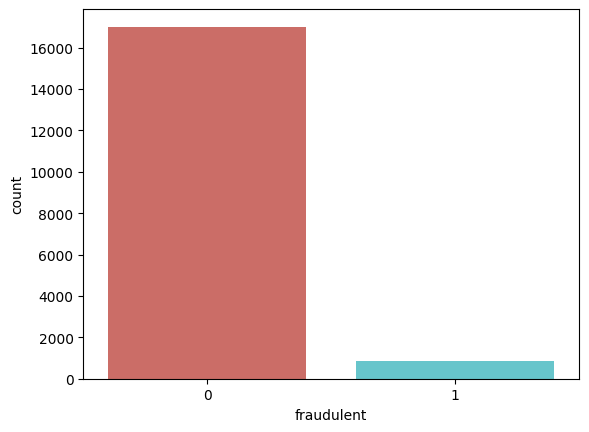

In [ ]:
sns.countplot(x='fraudulent', data=df, palette='hls')
plt.show()


In [ ]:
df['employment_type'].value_counts()

,count
employment_type,
Full-time,11620
No Data,3471
Contract,1524
Part-time,797
Temporary,241
Other,227


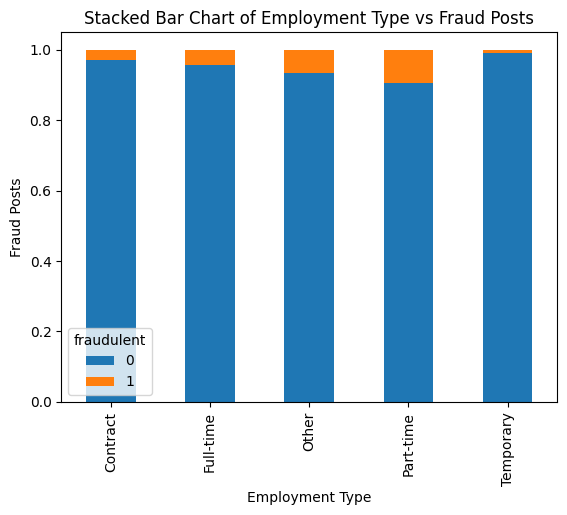

In [ ]:
table=pd.crosstab(df.employment_type, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Employment Type vs Fraud Posts')
plt.xlabel('Employment Type')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df['required_experience'].value_counts()

,count
required_experience,
Mid-Senior level,3809
Entry level,2697
Associate,2297
Not Applicable,1116
Director,389
Internship,381
Executive,141


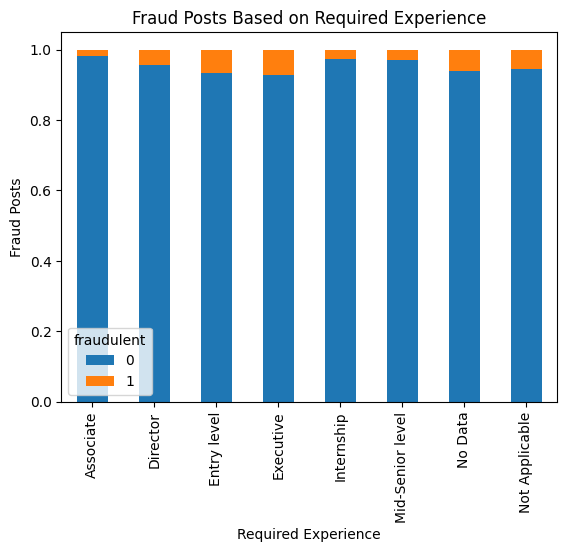

In [ ]:
%matplotlib inline

table=pd.crosstab(df.required_experience, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Fraud Posts Based on Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df['required_education'].value_counts()

,count
required_education,
Bachelor's Degree,5145
High School or equivalent,2080
Unspecified,1397
Master's Degree,416
Associate Degree,274
Certification,170
Some College Coursework Completed,102
Professional,74
Vocational,49


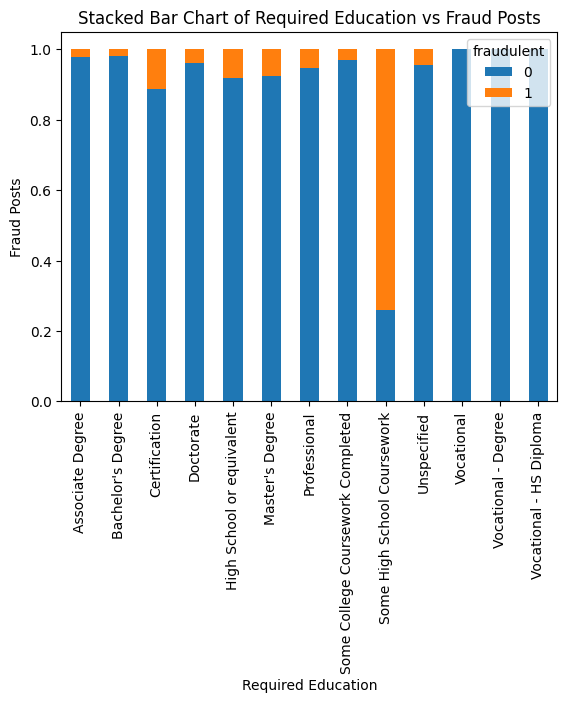

In [ ]:
table=pd.crosstab(df.required_education, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Required Education vs Fraud Posts')
plt.xlabel('Required Education')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df[(df['required_education'] == 'Some High School Coursework') & (df['fraudulent'] == 1)].shape[0] #20 fraud posts out of 27 total posts

20

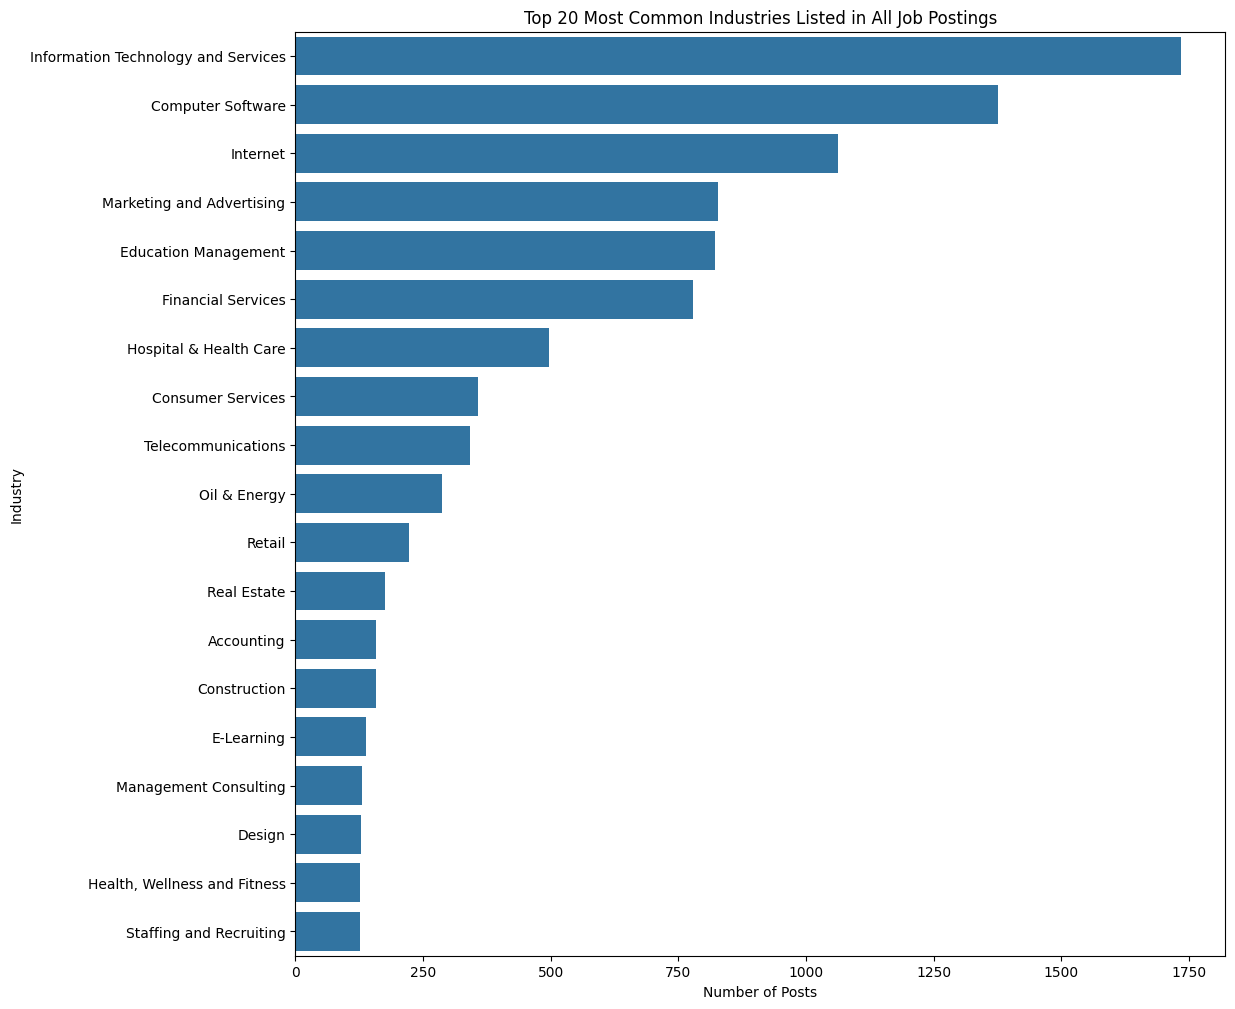

In [ ]:
import collections # Import the collections module
from collections import Counter # Import the Counter class from the collections module
import seaborn as sns # Import the seaborn library and assign it to the alias 'sns'

#top 20 most common industries - ALL POSTS
industry=list(df['industry'])
counts = Counter(industry).most_common(20) # Use the Counter class to count the frequency of industries
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in All Job Postings")
plt.show()
#top 5: no data, information technology&services, computer software, internet, education management

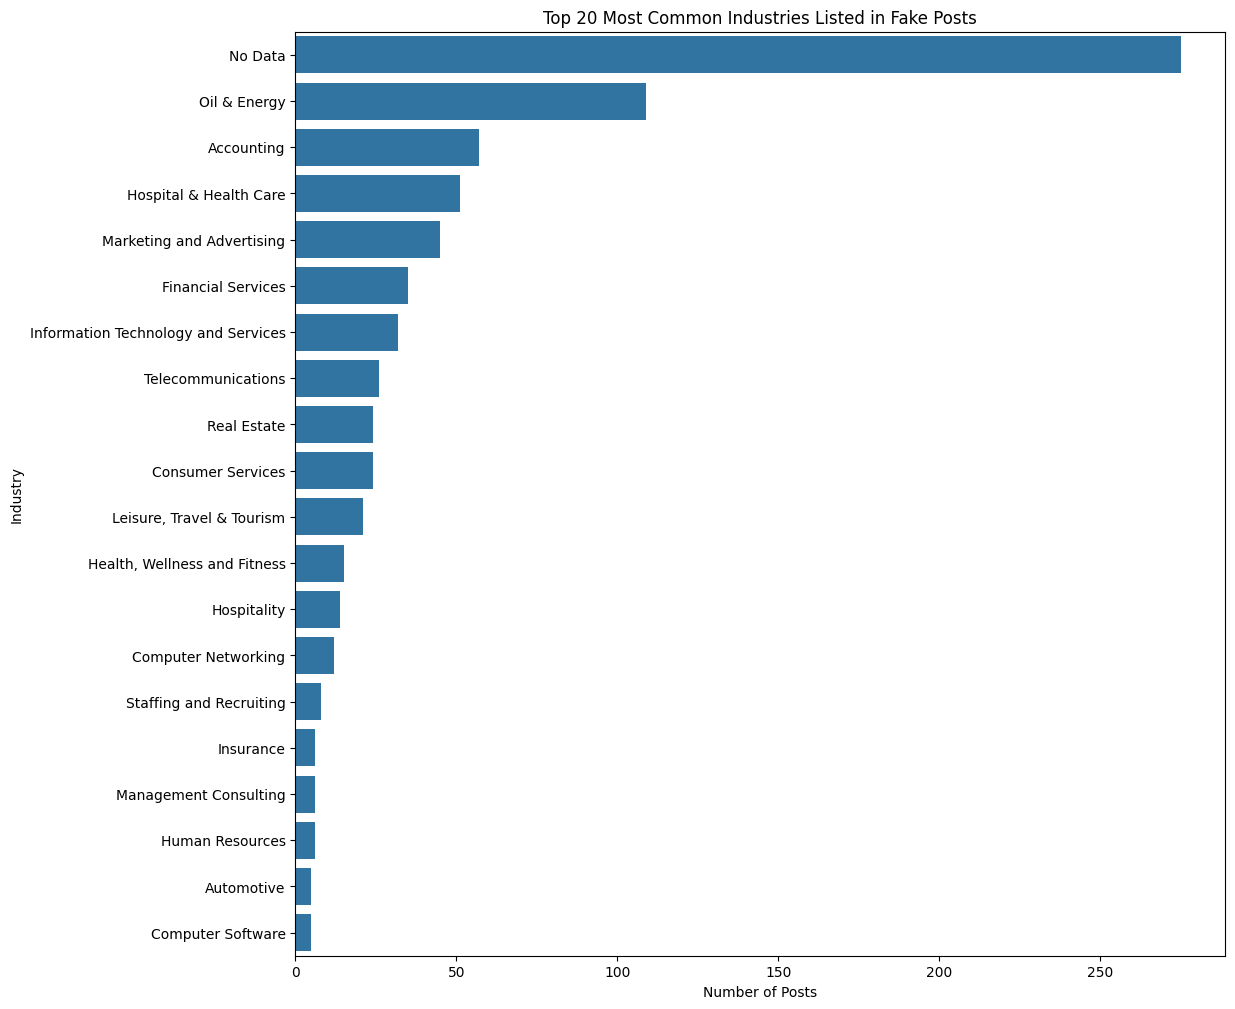

In [ ]:
#top 20 most common industries - FRAUD POSTS
#fraud_df was not defined prior to its use
#it should be assigned the values of the dataframe 'df' where the 'fraudulent' column is equal to 1
fraud_df = df[df['fraudulent'] == 1] #define fraud_df
industry=list(fraud_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Fake Posts")
plt.show()
#top 5: no data, oil&energy, accounting, hospital&health care, marketing&advertising

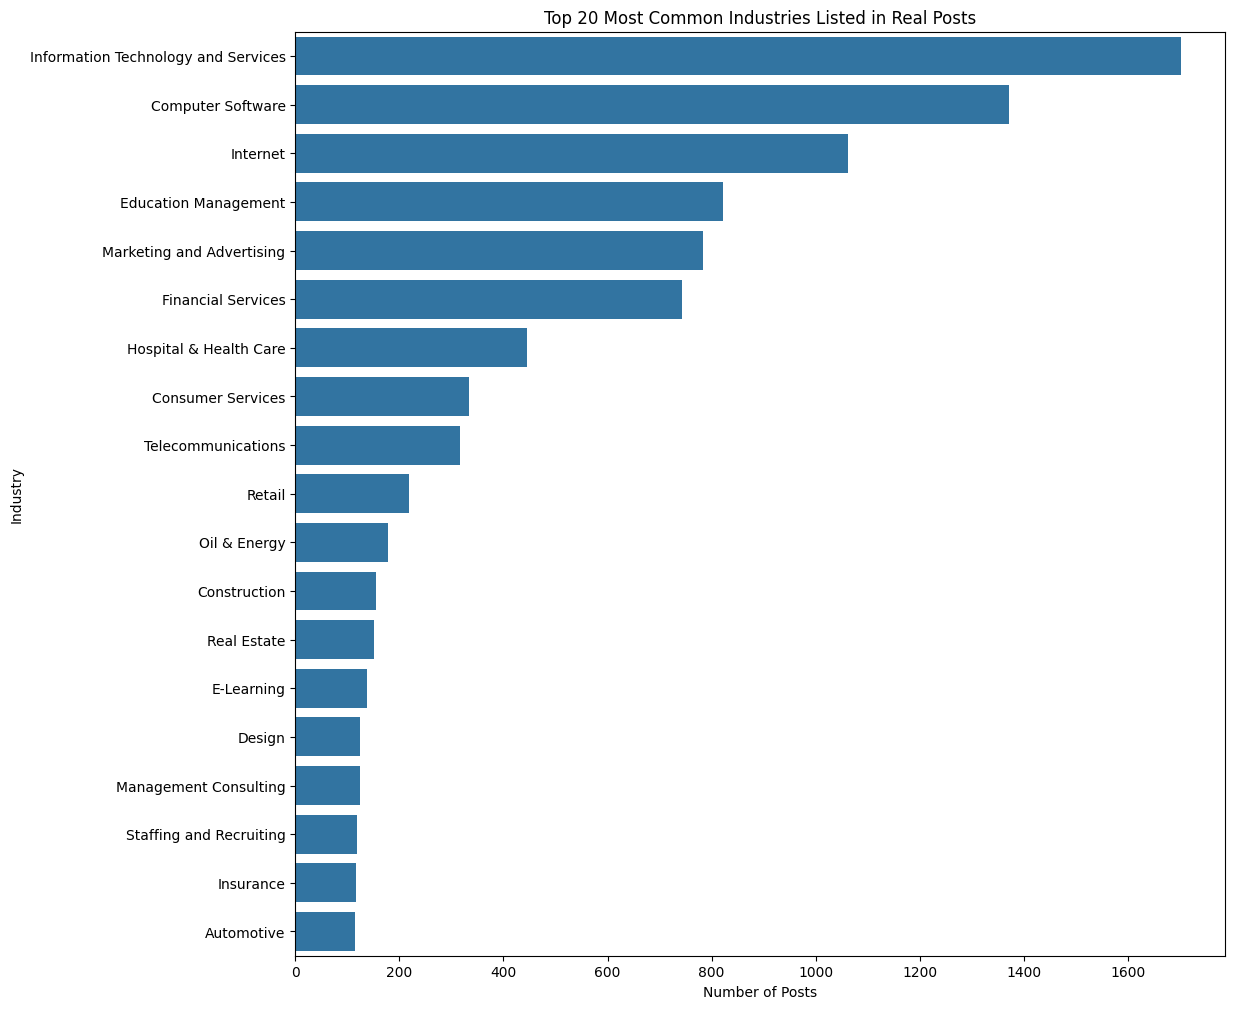

In [ ]:
#top 20 most common industries - REAL POSTS
# Create real_df if it doesn't exist
real_df = df[df['fraudulent'] == 0]
industry=list(real_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Real Posts")
plt.show()
#top 5: no data, information technology&services, computer software, internet, education management

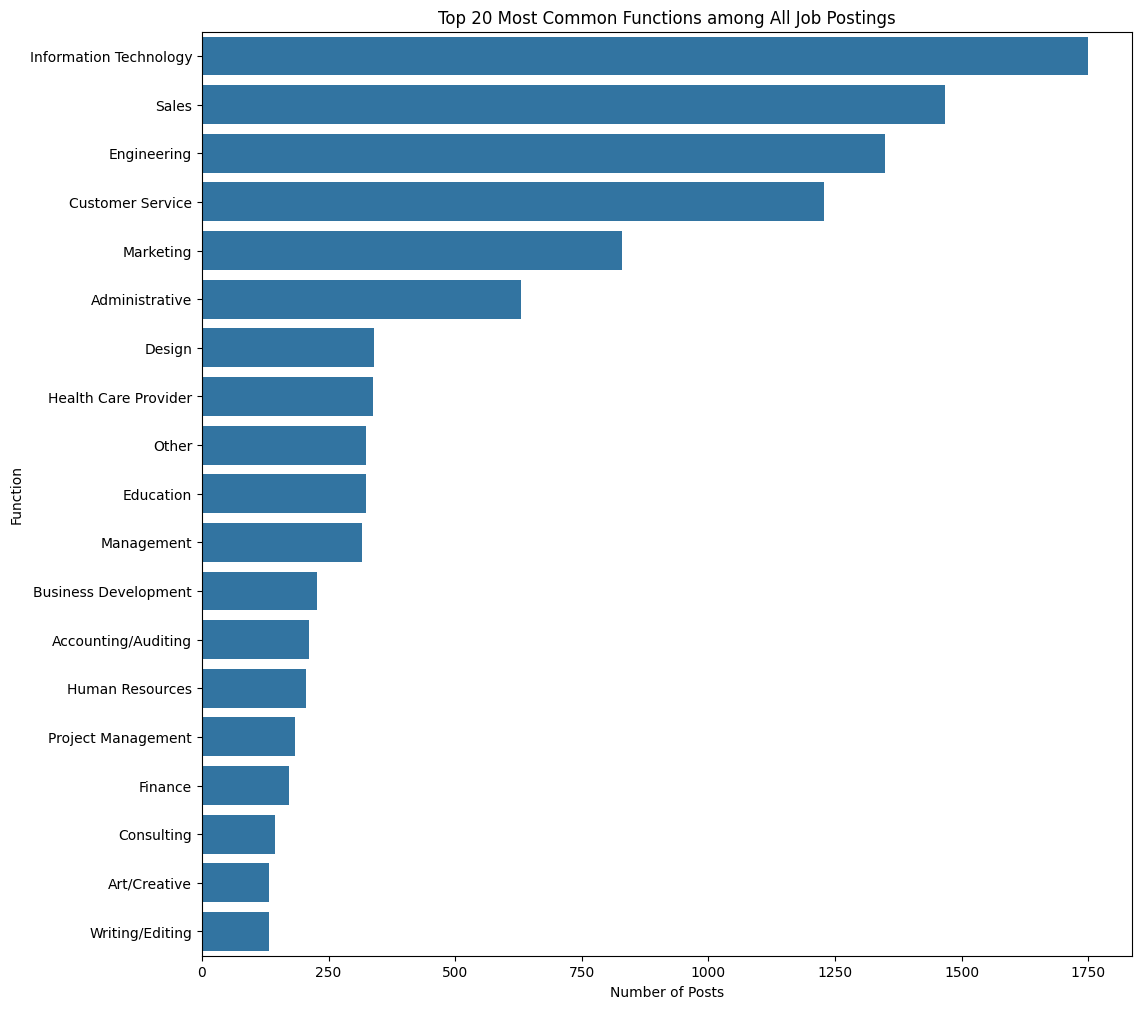

In [ ]:
#top 20 most common functions in ALL JOB POSTINGS
function=list(df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions among All Job Postings')
plt.show()
#top 5 = no data, administrative, engineering, customer service, sales

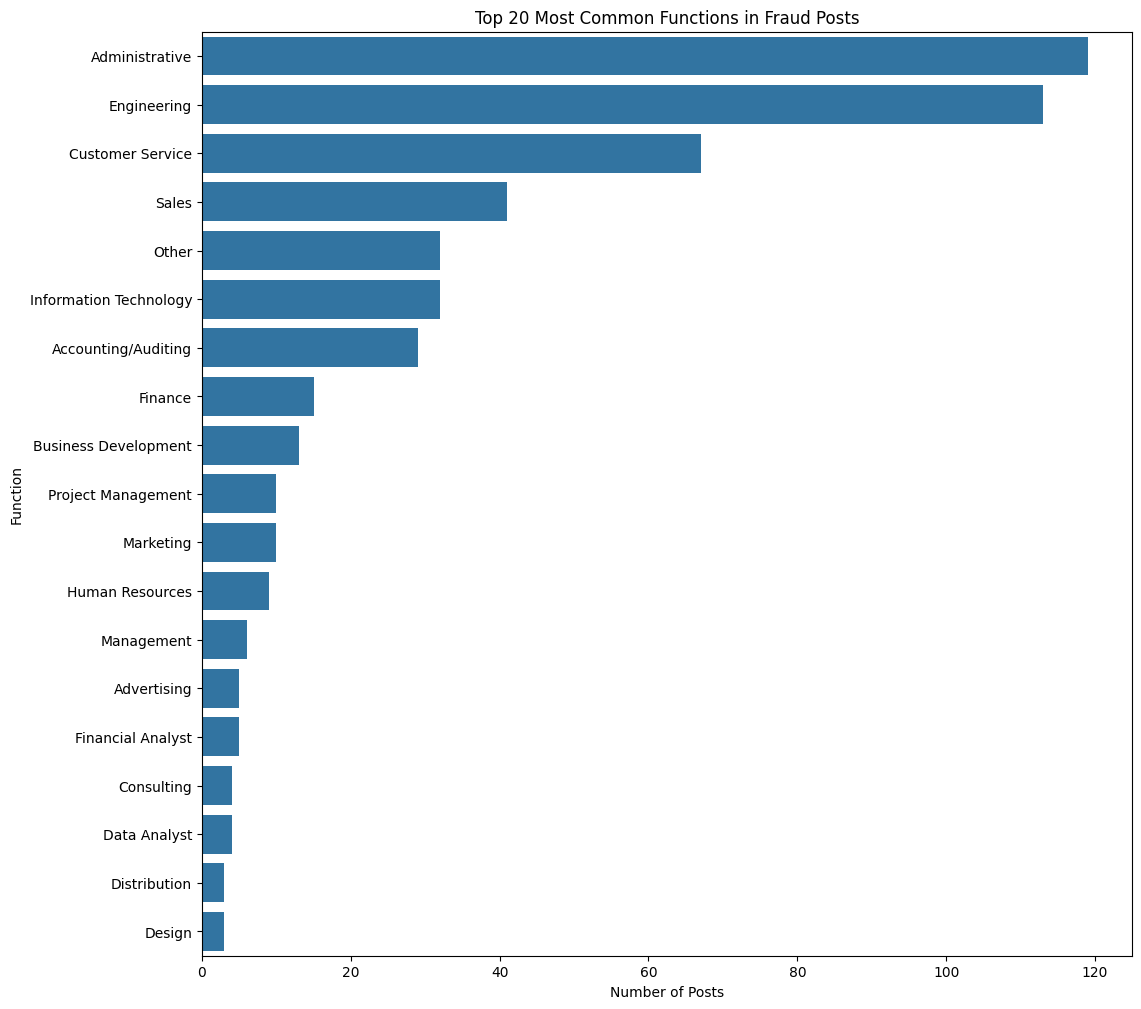

In [ ]:
#top 20 most common functions in fraud posts
function=list(fraud_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Fraud Posts')
plt.show()
#top 5 = no data, administrative, engineering, customer service, sales

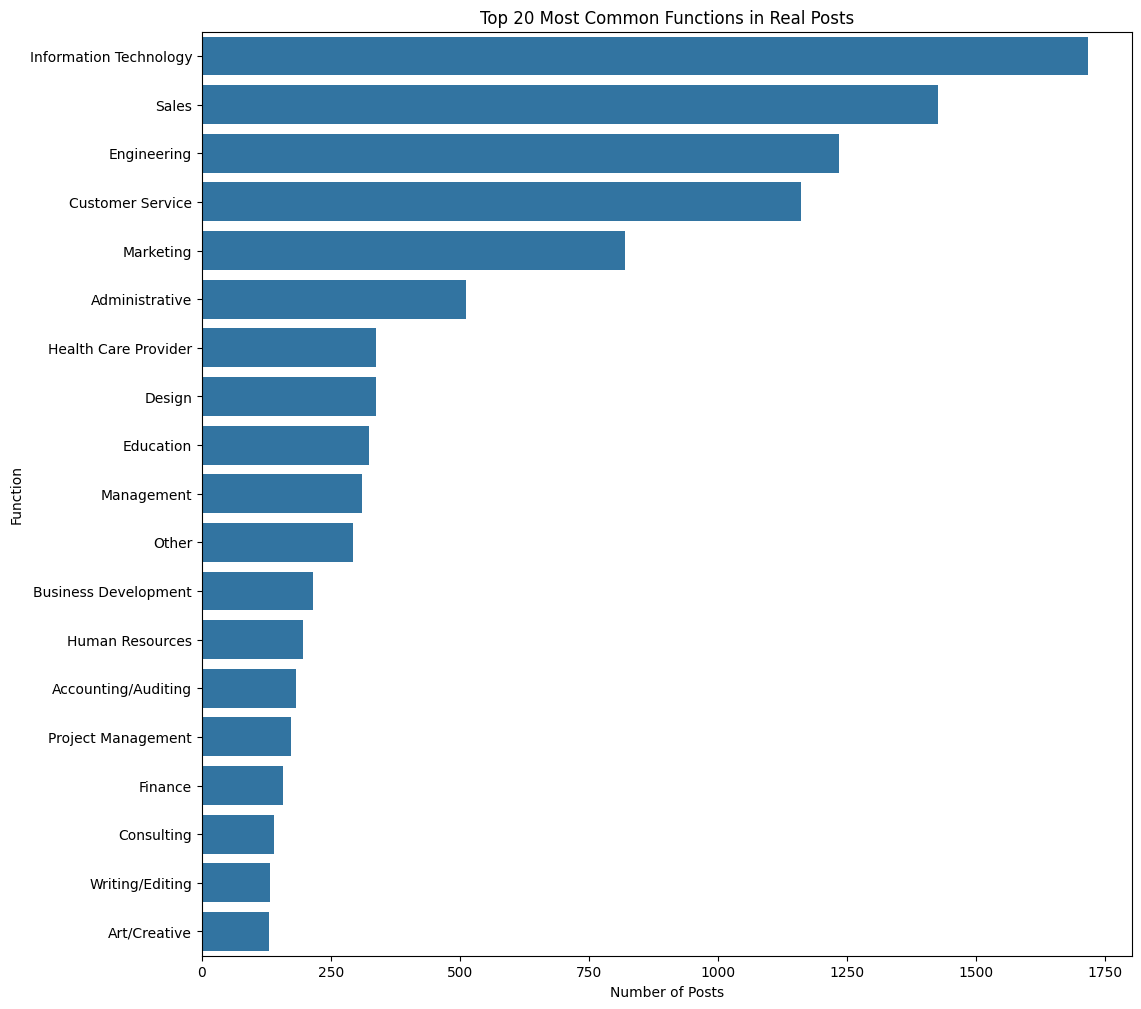

In [ ]:
#top 20 most common functions in real posts
function=list(real_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Real Posts')
plt.show()
#top 5 = no data, information technology, sales, engineering, customer service


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'salary_low', 'salary_high'],
      dtype='object')


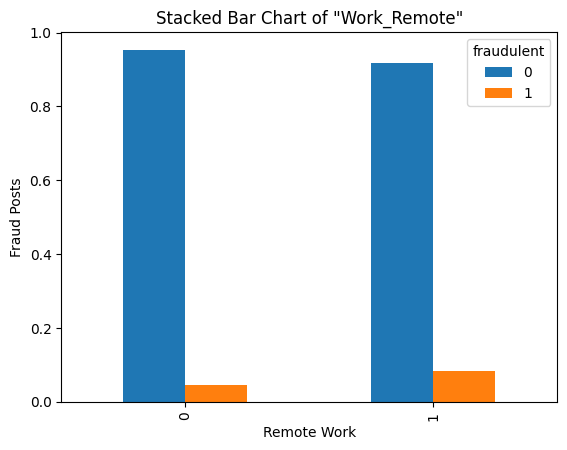

In [ ]:
# Before running the crosstab, check the columns of df_preproc_done
print(df_preproc_done.columns)

# Assuming 'work_remote' was renamed to 'telecommuting' during preprocessing,
# replace 'df_preproc_done.work_remote' with 'df_preproc_done.telecommuting'
# If the column was dropped, you need to add it back or use a different column.
table=pd.crosstab(df_preproc_done['telecommuting'], df_preproc_done.fraudulent)

table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Work_Remote"')
plt.xlabel('Remote Work')
plt.ylabel('Fraud Posts')
plt.show()

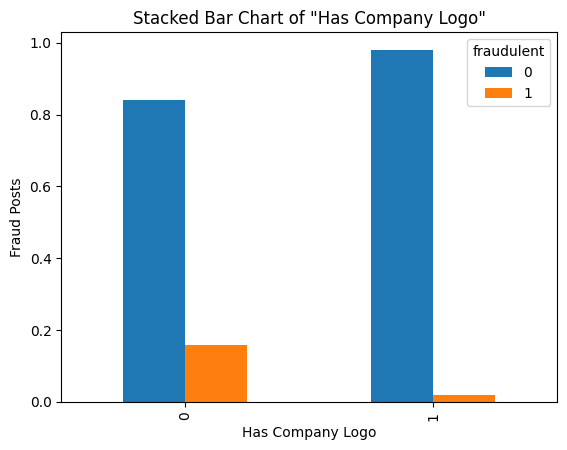

In [ ]:
table=pd.crosstab(df.has_company_logo, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Company Logo"')
plt.xlabel('Has Company Logo')
plt.ylabel('Fraud Posts')
plt.show()

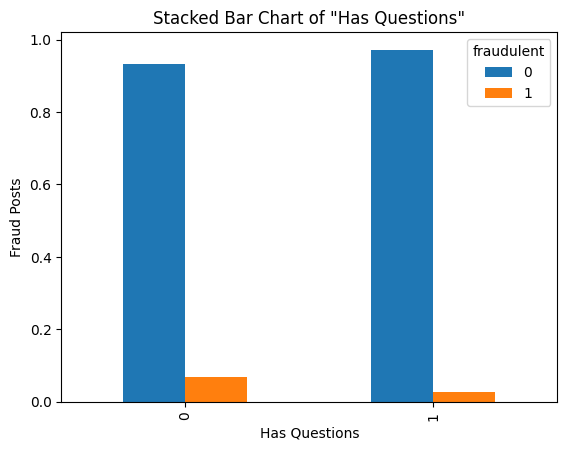

In [ ]:
table=pd.crosstab(df.has_questions, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Questions"')
plt.xlabel('Has Questions')
plt.ylabel('Fraud Posts')
plt.show()


One-Hot Encode Categorical Variables

In [ ]:
print("Shape before one-hot-encoding:", df.shape)

Shape before one-hot-encoding: (17880, 11)


In [ ]:
df = pd.get_dummies(df, columns=['employment_type', 'required_experience', 'required_education', 'industry', 'function']) #categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
print('Shape after one-hot-encoding:',df.shape) #(17880, 205)
df.head(1)

Shape after one-hot-encoding: (17880, 199)


,full_text,salary_range,work_remote,has_company_logo,has_questions,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_Other,employment_type_Part-time,...,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
0,NaN,NaN,0,1,0,0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


Split Data into Train, Val, and Test Sets
The data had already been split to get the salary mean for the training set, but now I will re-split it again (random_state = 1 will ensure that results were same as before) now that there are no NA values.

In [ ]:
print('dataframe shape:',df.shape)
train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
# print("train shape:",train.shape)

train_x, val_x= train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)
print('test shape:',test_x.shape)

dataframe shape: (17880, 199)
train_x shape: (11443, 199)
val shape: (2861, 199)
test shape: (3576, 199)


In [ ]:
train_x.nunique() #can't see all unique values so going to break it down into 5 sets of 41 columns


,0
full_text,2365
salary_range,651
work_remote,2
has_company_logo,2
has_questions,2
...,...
function_Science,2
function_Strategy/Planning,2
function_Supply Chain,2
function_Training,2


In [ ]:
train_x.nunique()[:41]

,0
full_text,2365
salary_range,651
work_remote,2
has_company_logo,2
has_questions,2
fraudulent,2
employment_type_Contract,2
employment_type_Full-time,2
employment_type_Other,2
employment_type_Part-time,2


In [ ]:
train_x.nunique()[41:82]


,0
industry_Broadcast Media,2
industry_Building Materials,2
industry_Business Supplies and Equipment,2
industry_Capital Markets,2
industry_Chemicals,2
industry_Civic & Social Organization,2
industry_Civil Engineering,2
industry_Commercial Real Estate,2
industry_Computer & Network Security,2
industry_Computer Games,2


In [ ]:
train_x.nunique()[82:123]

,0
industry_Hospital & Health Care,2
industry_Hospitality,2
industry_Human Resources,2
industry_Import and Export,2
industry_Individual & Family Services,2
industry_Industrial Automation,2
industry_Information Services,2
industry_Information Technology and Services,2
industry_Insurance,2
industry_International Trade and Development,2


In [ ]:
train_x.nunique()[123:164]

,0
industry_Packaging and Containers,2
industry_Performing Arts,2
industry_Pharmaceuticals,2
industry_Philanthropy,2
industry_Photography,2
industry_Plastics,2
industry_Primary/Secondary Education,2
industry_Printing,2
industry_Professional Training & Coaching,2
industry_Program Development,2


In [ ]:
train_x.nunique()[164:]

,0


In [ ]:
# Check if 'industry_Libraries' is in the columns of train_x, val_x, and test_x
print("'industry_Libraries' in train_x:", 'industry_Libraries' in train_x.columns)
print("'industry_Libraries' in val_x:", 'industry_Libraries' in val_x.columns)
print("'industry_Libraries' in test_x:", 'industry_Libraries' in test_x.columns)

# If 'industry_Libraries' is not in the columns, you can either:
# 1. Skip this analysis for 'industry_Libraries'
# 2. Add a new column with all values set to 0 to represent this industry

# Option 1: Skip analysis
if 'industry_Libraries' not in train_x.columns:
    print("Skipping analysis for 'industry_Libraries' as it is not present in the data.")
else:
    print('industry_Libraries')
    print('Train:\n',train_x['industry_Libraries'].value_counts())
    print('Val:\n', val_x['industry_Libraries'].value_counts())
    print('Test:\n', test_x['industry_Libraries'].value_counts())

# Option 2: Add a new column with 0 values
# (Only if you want to include this industry in the analysis)
for df in [train_x, val_x, test_x]:
    if 'industry_Libraries' not in df.columns:
        df['industry_Libraries'] = 0  # Add a new column with 0 values

'industry_Libraries' in train_x: True
'industry_Libraries' in val_x: True
'industry_Libraries' in test_x: True
industry_Libraries
Train:
 industry_Libraries
False    11443
Name: count, dtype: int64
Val:
 industry_Libraries
False    2860
True        1
Name: count, dtype: int64
Test:
 industry_Libraries
False    3575
True        1
Name: count, dtype: int64


In [ ]:
# Check if 'industry_Wine and Spirits' is in the columns of train_x, val_x, and test_x
print("'industry_Wine and Spirits' in train_x:", 'industry_Wine and Spirits' in train_x.columns)
print("'industry_Wine and Spirits' in val_x:", 'industry_Wine and Spirits' in val_x.columns)
print("'industry_Wine and Spirits' in test_x:", 'industry_Wine and Spirits' in test_x.columns)

# If 'industry_Wine and Spirits' is not in the columns, you can either:
# 1. Skip this analysis for 'industry_Wine and Spirits'
# 2. Add a new column with all values set to 0 to represent this industry

# Option 1: Skip analysis
if 'industry_Wine and Spirits' not in train_x.columns:
    print("Skipping analysis for 'industry_Wine and Spirits' as it is not present in the data.")
else:
    # Continue with your analysis if the column is present
    print('industry_Wine and Spirits')
    print('Train:\n',train_x['industry_Wine and Spirits'].value_counts())
    print('Val:\n', val_x['industry_Wine and Spirits'].value_counts())
    print('Test:\n', test_x['industry_Wine and Spirits'].value_counts())

# Option 2: Add a new column with 0 values
# (Only if you want to include this industry in the analysis)
for df in [train_x, val_x, test_x]:
    if 'industry_Wine and Spirits' not in df.columns:
        df['industry_Wine and Spirits'] = 0  # Add a new column with 0 values

'industry_Wine and Spirits' in train_x: False
'industry_Wine and Spirits' in val_x: False
'industry_Wine and Spirits' in test_x: False
Skipping analysis for 'industry_Wine and Spirits' as it is not present in the data.


In [ ]:
# Check if 'industry_Wine and Spirits' is in the columns of train_x, val_x, and test_x
print("'industry_Wine and Spirits' in train_x:", 'industry_Wine and Spirits' in train_x.columns)
print("'industry_Wine and Spirits' in val_x:", 'industry_Wine and Spirits' in val_x.columns)
print("'industry_Wine and Spirits' in test_x:", 'industry_Wine and Spirits' in test_x.columns)

# If 'industry_Wine and Spirits' is not in the columns, you can either:
# 1. Skip this analysis for 'industry_Wine and Spirits'
# 2. Add a new column with all values set to 0 to represent this industry

# Option 1: Skip analysis
if 'industry_Wine and Spirits' not in train_x.columns:
    print("Skipping analysis for 'industry_Wine and Spirits' as it is not present in the data.")
else:
    # Continue with your analysis if the column is present
    print('industry_Wine and Spirits')
    print('Train:\n',train_x['industry_Wine and Spirits'].value_counts())
    print('Val:\n', val_x['industry_Wine and Spirits'].value_counts())
    print('Test:\n', test_x['industry_Wine and Spirits'].value_counts())

# Option 2: Add a new column with 0 values
# (Only if you want to include this industry in the analysis)
for df in [train_x, val_x, test_x]:
    if 'industry_Wine and Spirits' not in df.columns:
        df['industry_Wine and Spirits'] = 0  # Add a new column with 0 values

'industry_Wine and Spirits' in train_x: True
'industry_Wine and Spirits' in val_x: True
'industry_Wine and Spirits' in test_x: True
industry_Wine and Spirits
Train:
 industry_Wine and Spirits
False    11443
Name: count, dtype: int64
Val:
 industry_Wine and Spirits
False    2860
True        1
Name: count, dtype: int64
Test:
 industry_Wine and Spirits
False    3576
Name: count, dtype: int64


In [ ]:
# Check if 'industry_Shipbuilding' is in the columns of train_x, val_x, and test_x
print("'industry_Shipbuilding' in train_x:", 'industry_Shipbuilding' in train_x.columns)
print("'industry_Shipbuilding' in val_x:", 'industry_Shipbuilding' in val_x.columns)
print("'industry_Shipbuilding' in test_x:", 'industry_Shipbuilding' in test_x.columns)

# If 'industry_Shipbuilding' is not in the columns, you can either:
# 1. Skip this analysis for 'industry_Shipbuilding'
# 2. Add a new column with all values set to 0 to represent this industry

# Option 1: Skip analysis
if 'industry_Shipbuilding' not in train_x.columns:
    print("Skipping analysis for 'industry_Shipbuilding' as it is not present in the data.")
else:
    print('industry_Shipbuilding')
    print('Train:\n',train_x['industry_Shipbuilding'].value_counts())
    print('Val:\n', val_x['industry_Shipbuilding'].value_counts())
    print('Test:\n', test_x['industry_Shipbuilding'].value_counts())

# Option 2: Add a new column with 0 values
# (Only if you want to include this industry in the analysis)
for df in [train_x, val_x, test_x]:
    if 'industry_Shipbuilding' not in df.columns:
        df['industry_Shipbuilding'] = 0  # Add a new column with 0 values

'industry_Shipbuilding' in train_x: False
'industry_Shipbuilding' in val_x: False
'industry_Shipbuilding' in test_x: False
Skipping analysis for 'industry_Shipbuilding' as it is not present in the data.


In [ ]:
# Check if 'industry_Shipbuilding' is in the columns of train_x, val_x, and test_x
print("'industry_Shipbuilding' in train_x:", 'industry_Shipbuilding' in train_x.columns)
print("'industry_Shipbuilding' in val_x:", 'industry_Shipbuilding' in val_x.columns)
print("'industry_Shipbuilding' in test_x:", 'industry_Shipbuilding' in test_x.columns)

# If 'industry_Shipbuilding' is not in the columns, you can either:
# 1. Skip this analysis for 'industry_Shipbuilding'
# 2. Add a new column with all values set to 0 to represent this industry

# Option 1: Skip analysis
if 'industry_Shipbuilding' not in train_x.columns:
    print("Skipping analysis for 'industry_Shipbuilding' as it is not present in the data.")
else:
    print('industry_Shipbuilding')
    print('Train:\n',train_x['industry_Shipbuilding'].value_counts())
    print('Val:\n', val_x['industry_Shipbuilding'].value_counts())
    print('Test:\n', test_x['industry_Shipbuilding'].value_counts())

# Option 2: Add a new column with 0 values
# (Only if you want to include this industry in the analysis)
for df in [train_x, val_x, test_x]:
    if 'industry_Shipbuilding' not in df.columns:
        df['industry_Shipbuilding'] = 0  # Add a new column with 0 values

'industry_Shipbuilding' in train_x: True
'industry_Shipbuilding' in val_x: True
'industry_Shipbuilding' in test_x: True
industry_Shipbuilding
Train:
 industry_Shipbuilding
False    11443
Name: count, dtype: int64
Val:
 industry_Shipbuilding
False    2861
Name: count, dtype: int64
Test:
 industry_Shipbuilding
False    3575
True        1
Name: count, dtype: int64


In [ ]:
print(val_x.nunique()[:41])
print(val_x.nunique()[41:82])
print(val_x.nunique()[82:123])
print(val_x.nunique()[123:164])
print(val_x.nunique()[164:])

job_id                       2861
full_text                     602
salary_range                  268
telecommuting                   2
has_company_logo                2
has_questions                   2
employment_type                 5
required_experience             7
required_education             12
industry                      109
function                       37
fraudulent                      2
salary_low                    104
salary_high                   120
industry_Libraries              1
industry_Wine and Spirits       1
industry_Shipbuilding           1
dtype: int64
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)
Series([], dtype: int64)


In [ ]:
print(test_x.nunique()[:41])
print(test_x.nunique()[41:82])
print(test_x.nunique()[82:123])
print(test_x.nunique()[123:164])
print(test_x.nunique()[164:])

full_text                                               769
salary_range                                            334
work_remote                                               2
has_company_logo                                          2
has_questions                                             2
fraudulent                                                2
employment_type_Contract                                  2
employment_type_Full-time                                 2
employment_type_Other                                     2
employment_type_Part-time                                 2
employment_type_Temporary                                 2
required_experience_Associate                             2
required_experience_Director                              2
required_experience_Entry level                           2
required_experience_Executive                             2
required_experience_Internship                            2
required_experience_Mid-Senior level    

In [ ]:
train_x['fraudulent'].value_counts()

,count
fraudulent,
0,10889
1,554


<ipython-input-49-20eeb7139d7b>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=train_x, palette='hls')


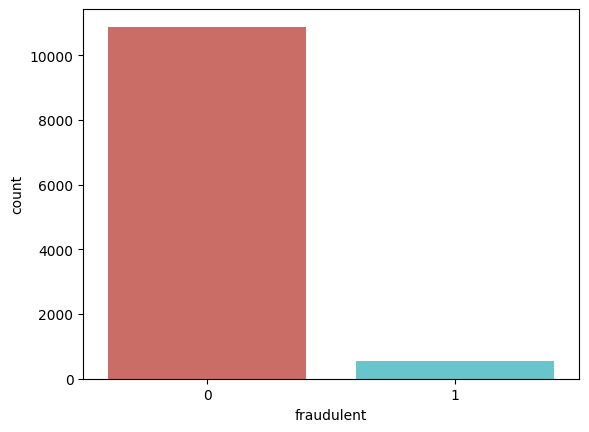

In [ ]:
sns.countplot(x='fraudulent', data=train_x, palette='hls')
plt.show()

Reducing the Training Dataset

In [ ]:
train_x['fraudulent'].value_counts() #I will keep all 554 fraudulent posts and instead just subsample the real posts using the sample(frac=0.5, random_state=1)


,count
fraudulent,
0,10889
1,554


In [ ]:
def undersample_data(new_df, col_name, val, fraction, seed):
  undersampled = new_df[new_df[col_name] == val]
  undersampled=undersampled.sample(frac=fraction, random_state=seed)
  # print(undersampled.shape)
  # print(undersampled['fraudulent'].value_counts()) #making sure only real data has been subsampled
  return undersampled

In [ ]:
fake_train = train_x[train_x['fraudulent'] == 1]
fake_train.shape


(554, 207)

In [ ]:
undersampled = undersample_data(train_x, 'fraudulent', 0, 0.5, 1)
# Use pd.concat instead of append
under_train_x = pd.concat([undersampled, fake_train], ignore_index=True)
under_train_x['fraudulent'].value_counts()

,count
fraudulent,
0,5444
1,554


In [ ]:
def undersample_data(new_df, col_name, val, fraction, seed):
  undersampled = new_df[new_df[col_name] == val]
  undersampled=undersampled.sample(frac=fraction, random_state=seed)
  # print(undersampled.shape)
  # print(undersampled['fraudulent'].value_counts()) #making sure only real data has been subsampled
  return undersampled

In [ ]:
fake_train = train_x[train_x['fraudulent'] == 1]
fake_train.shape

(554, 199)

In [ ]:
# Define the undersample_data function before calling it
def undersample_data(new_df, col_name, val, fraction, seed):
    undersampled = new_df[new_df[col_name] == val]
    undersampled = undersampled.sample(frac=fraction, random_state=seed)
    return undersampled

# Now you can call the function
fake_train = train_x[train_x['fraudulent'] == 1]
fake_train.shape

undersampled = undersample_data(train_x, 'fraudulent', 0, 0.5, 1)
# Replace the following line:
# under_train_x = undersampled.append(fake_train)
# with:
under_train_x = pd.concat([undersampled, fake_train], ignore_index=True)  # Use pd.concat to combine DataFrames
under_train_x['fraudulent'].value_counts()

,count
fraudulent,
0,5444
1,554


In [ ]:
under_train_x_labels = under_train_x['fraudulent']

<ipython-input-55-2e59ad352c88>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=under_train_x, palette='hls') #approximately a 90/10 ratio


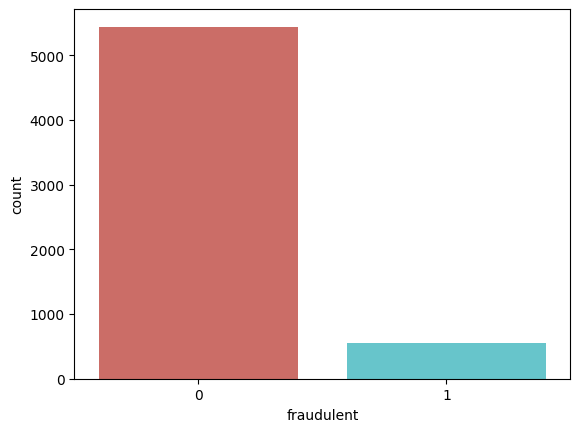

In [ ]:
sns.countplot(x='fraudulent', data=under_train_x, palette='hls') #approximately a 90/10 ratio
plt.show()


Base Model - RNN with Embedding Layer
Numeric + Text Inputs
Building the Model with Numeric and Text Data

In [ ]:
#TextVectorization layer:
#turns raw strings into an encoded representation that can be read by an Embedding layer or Dense layer
#TextVectorization(max_tokens, standardize, split, ngrams, output_mode, output_sequence_length, pad_to_max_tokens)

def vectorize(text):
  vectorize_layer = TextVectorization(
      output_mode='int',
      max_tokens=128)
      #output_sequence_length=512 gave 125,764 total vocabulary size

  vectorize_layer.adapt(np.asarray(text)) #builds vocabulary
  return vectorize_layer


In [ ]:
# Recreate the 'full_text' column by combining the relevant text columns
# Assuming you want to concatenate all the columns into 'full_text'
# df_preproc_done contains the original columns

# Instead of using df, which has modified columns, use df_preproc_done
df['full_text'] = df_preproc_done['title'] + " " + df_preproc_done['location'] + " " + df_preproc_done['department'] + " " + df_preproc_done['company_profile'] + " " + df_preproc_done['description'] + " " + df_preproc_done['requirements'] + " " + df_preproc_done['benefits']

# Now you can proceed with the rest of the operations
# Assign 'full_text' to 'title' if needed
df['title'] = df['full_text']  # Assign 'full_text' to 'title'
df.drop(columns=['location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'full_text'], inplace=True, errors='ignore')
df.rename(columns={'title': 'full_text'}, inplace=True)

In [ ]:
# ... (previous code) ...

# Define 'text' by selecting the 'full_text' column from the DataFrame 'df'
# Convert the 'full_text' column to string type and replace NaN values with empty strings
text = df['full_text'].astype(str).fillna('').values

vocab = vectorize(text)
vocab = list(vocab.get_vocabulary())
print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}")

# ... (rest of the code) ...

Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', np.str_('and'), np.str_('the'), np.str_('to'), np.str_('of'), np.str_('a'), np.str_('in'), np.str_('with'), np.str_('for'), np.str_('is'), np.str_('our'), np.str_('we'), np.str_('nan'), np.str_('you'), np.str_('are'), np.str_('on'), np.str_('be'), np.str_('work'), np.str_('as')]
Last 20 words in vocab: [np.str_('benefits'), np.str_('do'), np.str_('strong'), np.str_('training'), np.str_('products'), np.str_('growth'), np.str_('need'), np.str_('client'), np.str_('digital'), np.str_('way'), np.str_('high'), np.str_('engineering'), np.str_('across'), np.str_('its'), np.str_('over'), np.str_('competitive'), np.str_('–'), np.str_('companies'), np.str_('join'), np.str_('if')]


In [ ]:
#Embedding Layer:
#Turns positive integers (indexes) into dense vectors of fixed size
# This layer can only be used as the first layer in a model

# tf.keras.layers.Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer="uniform",
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     **kwargs
# )

In [ ]:
# ... (previous code) ...

# Instead of recreating 'full_text', just use the existing 'full_text' column
# df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits']

# Now you can proceed with the rest of the operations
# The 'full_text' column already exists, so you can use it directly
text = df['full_text'].astype(str).fillna('').values

# ... (rest of the code) ...

In [ ]:
train_numeric = train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
val_numeric = val_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
test_numeric = test_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
undersampled_numeric = under_train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()

print(train_numeric.shape, val_numeric.shape, test_numeric.shape, undersampled_numeric)

(11443, 197) (2861, 197) (3576, 197) [[nan 0 1 ... False False False]
 [nan 0 1 ... False False True]
 ['55000-75000' 0 0 ... False False False]
 ...
 [nan 0 0 ... False False False]
 [nan 0 0 ... False False False]
 [nan 0 0 ... False False False]]


In [ ]:
train_labels = train_x['fraudulent'].to_numpy()
val_labels = val_x['fraudulent'].to_numpy()
test_labels = test_x['fraudulent'].to_numpy()
undersampled_labels = under_train_x['fraudulent'].to_numpy()

print(train_labels.shape, val_labels.shape, test_labels.shape, undersampled_labels.shape)


(11443,) (2861,) (3576,) (5998,)


In [ ]:
# Assuming 'full_text' is the text column and 'fraudulent' is the label column
train_numeric = train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy() # Extract numeric features
# ... (other code) ...

# Assign the 'full_text' data to 'train_text', 'val_text', 'test_text'
train_text = train_x['full_text'].to_numpy()
# ... (other code) ...

# Now you can use train_text and train_numeric in your print statement
print('Text:', train_text[0])
print('Numeric Variables:\n', train_numeric[0]) # This should now work without error
print('Label:', train_labels[0])

Text: nan
Numeric Variables:
 [nan 0 1 0 False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False Fals

In [ ]:
metrics_list = [
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
  ]

def build_rnn_model():
  text_inputs=tf.keras.Input(shape=(1,), dtype=tf.string, name='text_inputs')
  text_outputs = vectorize(text_inputs) #text_outputs.dtype = 'tf.int64'
  i = layers.Embedding(len(vectorize.get_vocabulary()), 128, input_length=128, mask_zero=True)(text_outputs) #changed from input_length=512
  i=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(i)

  numeric_inputs = tf.keras.Input(shape=(203,), name='numeric_inputs')
  j=layers.Dense(128, activation='relu', name='dense_j1',
                kernel_initializer=tf.keras.initializers.he_normal(seed=1))(numeric_inputs)
  j=layers.Dropout(0.1)(j)
  j=layers.Dense(128, activation='relu', name='dense_j2',
                kernel_initializer=tf.keras.initializers.he_normal(seed=1))(j) #j.dtype='float32'

  inputs = keras.layers.concatenate([i, j])
  x = layers.Dense(32, activation='relu', name='layer1')(inputs)
  # x=layers.Dropout(0.2, name='dropout1')(x)
  # x = layers.Dense(32, activation='relu', name='layer2')(x)
  # x=layers.Dropout(0.2, name='dropout2')(x)
  output=layers.Dense(1, activation='sigmoid', name='final_output')(x)

  rnn_model = Model(inputs=[text_inputs, numeric_inputs], outputs=[output])
  return rnn_model

In [ ]:
def build_rnn_model():
    model = keras.Sequential([
        layers.Embedding(input_dim=10000, output_dim=16),
        layers.SimpleRNN(32, return_sequences=True),
        layers.SimpleRNN(32),
        layers.Dense(1, activation="sigmoid")
    ])
    return model  # Make sure the model is returned!
    print(build_rnn_model)  # Should print a function reference
    model_rnn = build_rnn_model()
    if model_rnn is None:
      print("Error: build_rnn_model() returned None")


In [ ]:
model_rnn = build_rnn_model()
print(model_rnn.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


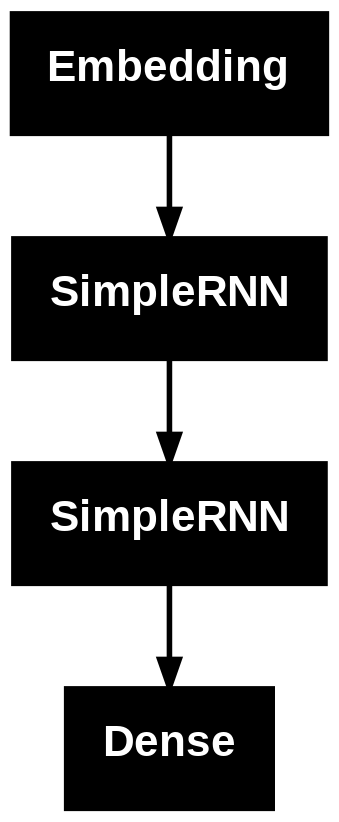

In [ ]:
model_rnn = build_rnn_model()
# Build the model by specifying the input shape
# Replace input_shape with the actual shape of your input data
# For example, if your text input has shape (batch_size, sequence_length) and
# your numeric input has shape (batch_size, num_features), then you would use:
# input_shape=[(batch_size, sequence_length), (batch_size, num_features)]
# In this case, we use a symbolic input to build the model
text_input_shape = (None,)  # Shape for text input (assuming variable length sequences)
numeric_input_shape = (203,)  # Shape for numeric input
model_rnn.build(input_shape=[text_input_shape, numeric_input_shape])

print(model_rnn.summary())
keras.utils.plot_model(model_rnn) # Call plot_model after building the model


Training the model with text + numeric variables


In [ ]:
from statistics import mean

In [ ]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)

In [ ]:
# Assuming 'full_text' is the text column and 'fraudulent' is the label column
# ... (other code) ...

# Assign the 'full_text' data to 'train_text', 'val_text', 'test_text'
train_text = train_x['full_text'].to_numpy()
val_text = val_x['full_text'].to_numpy()  # Extract and assign validation text data
test_text = test_x['full_text'].to_numpy()  # Extract and assign test text data

# ... (other code) ...

# Now you can use train_text, val_text, and train_numeric in your print statement and model training
print('Text:', train_text[0])
print('Numeric Variables:\n', train_numeric[0])
print('Label:', train_labels[0])

# ... (other code) ...

history = model_rnn.fit([train_text, train_numeric], train_labels, epochs=5, validation_data=([val_text, val_numeric], val_labels))

Text: nan
Numeric Variables:
 nan
Label: 0


ValueError: You must call `compile()` before using the model.

In [ ]:
history.history

NameError: name 'history' is not defined

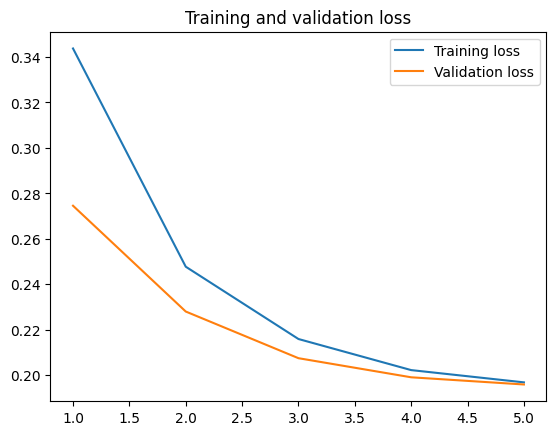

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


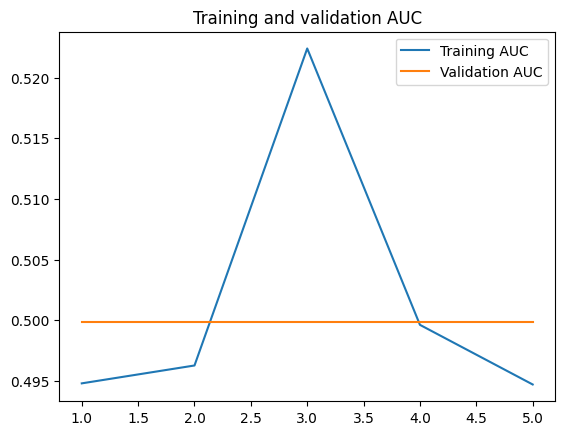

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.show()


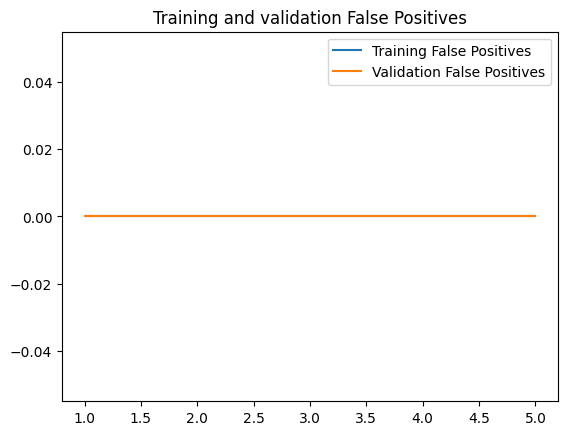

In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives')
plt.legend()
plt.show()

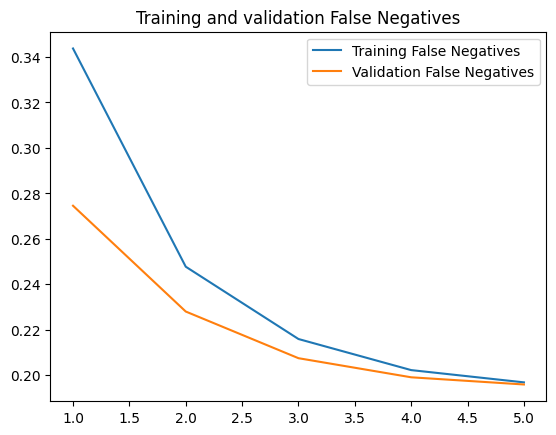

In [ ]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives')
plt.legend()
plt.show()

Comparing these results with training the model on undersampled training data (validation data remains the same)

In [ ]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)

In [ ]:
# Before converting to float32, replace salary ranges with numerical values
# You might need to adjust this logic based on your specific data
# For example, you could replace '60000-80000' with the average (70000)
# or with separate columns for low and high salary
import numpy as np

def replace_salary_range(value):
    if isinstance(value, str) and '-' in value:
        try:
            low, high = map(float, value.split('-'))
            return (low + high) / 2  # Replace with average
        except ValueError:
            return np.nan  # Or any other value to handle invalid ranges
    else:
        return value

# Apply the function to the numeric columns
undersampled_numeric = np.vectorize(replace_salary_range, otypes=[float])(undersampled_numeric) # Specify otypes=[float]


# Impute missing values if necessary
# For example, fill NaN values with the column mean:
# undersampled_numeric = np.nan_to_num(undersampled_numeric, nan=np.nanmean(undersampled_numeric, axis=0))

# Now, you can safely convert to float32
undersampled_numeric = undersampled_numeric.astype('float32')

In [ ]:
history.history

{'accuracy': [0.951586127281189,
  0.951586127281189,
  0.951586127281189,
  0.951586127281189,
  0.951586127281189],
 'auc': [0.4947955906391144,
  0.4962686598300934,
  0.5224006772041321,
  0.4996184706687927,
  0.494703471660614],
 'fn': [554.0, 554.0, 554.0, 554.0, 554.0],
 'fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'loss': [0.3437085747718811,
  0.247747540473938,
  0.21594448387622833,
  0.20227637887001038,
  0.19688758254051208],
 'val_accuracy': [0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866],
 'val_auc': [0.49981629848480225,
  0.49981629848480225,
  0.49981629848480225,
  0.49981629848480225,
  0.49981629848480225],
 'val_fn': [139.0, 139.0, 139.0, 139.0, 139.0],
 'val_fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.2745572328567505,
  0.22803577780723572,
  0.2075112760066986,
  0.19911354780197144,
  0.19595590233802795]}

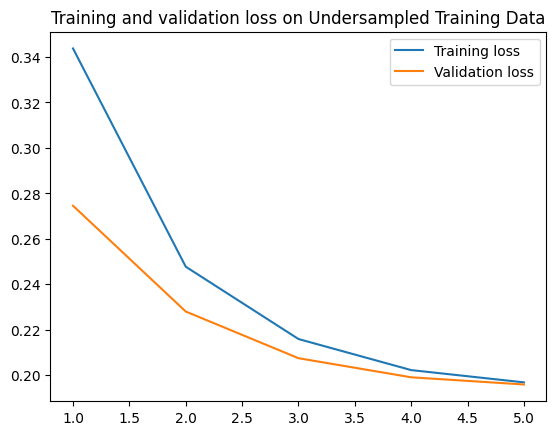

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss on Undersampled Training Data')
plt.legend()
plt.show()

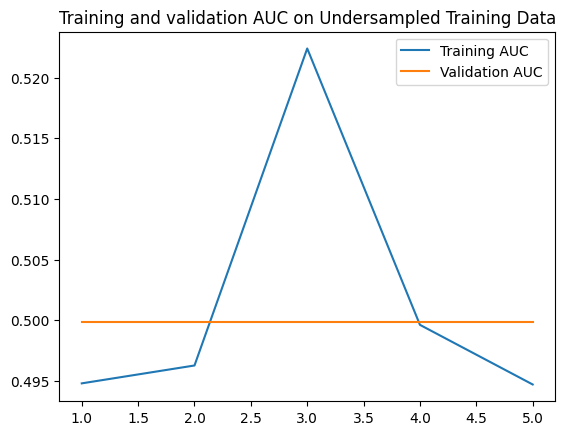

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC on Undersampled Training Data')
plt.legend()
plt.show()


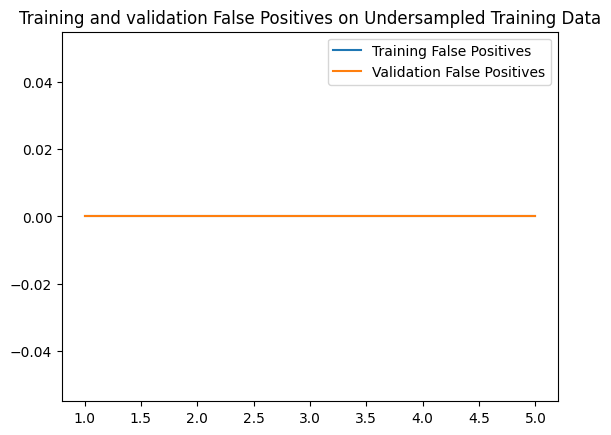

In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives on Undersampled Training Data')
plt.legend()
plt.show()

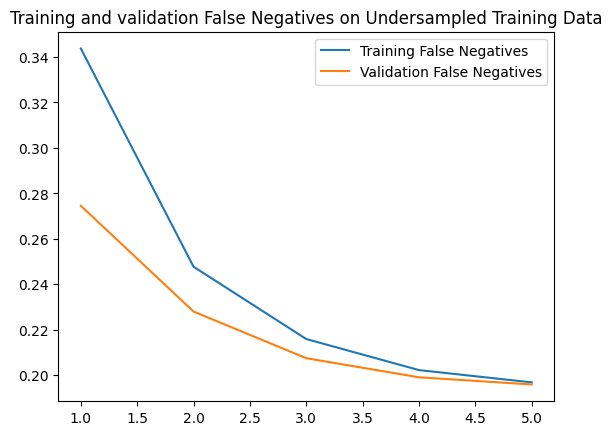

In [ ]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives on Undersampled Training Data')
plt.legend()
plt.show()


Retraining the entire model for the test set with text + numeric variables
Note: I ran this section initially but due to the low AUC values during the training phase, I know that the text-only data significantly improved the AUC so I will not rerun this section. All code was left but it has been commented out.

In [ ]:
# total_train_numeric=np.concatenate((train_numeric,val_numeric))
# total_train_text=np.concatenate((train_text,val_text))
# total_train_labels= np.concatenate((train_labels, val_labels))

# model_rnn2 = build_rnn_model()
# model_rnn2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
#                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                     metrics=metrics_list)
# print(model_rnn2.summary())


In [ ]:
# keras.utils.plot_model(model_rnn2)

In [ ]:
# history2 = model_rnn2.fit([total_train_text, total_train_numeric], total_train_labels, epochs=5, validation_data=([test_text, test_numeric], test_labels))


In [ ]:

# history2.history


In [ ]:
# combo_auc = history2.history['auc']
# test_auc = history2.history['val_auc']
# print(f"Train+Val Average Mean: {mean(combo_auc)}; Test Average Mean: {mean(test_auc)}")


In [ ]:
# loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']
# epochs2 = range(1, len(loss2) + 1)
# plt.figure()
# plt.plot(epochs2, loss2, label='Training loss')
# plt.plot(epochs2, val_loss2, label='Validation loss')
# plt.title('Train+Validation and Testing loss (Text Only Data)')
# plt.legend()
# plt.show()

In [ ]:
# auc2 = history2.history['auc']
# val_auc2 = history2.history['val_auc']
# epochs2 = range(1, len(auc2) + 1)
# plt.figure()
# plt.plot(epochs2, auc2, label='Training AUC')
# plt.plot(epochs2, val_auc2, label='Validation AUC')
# plt.title('Train+Validation and Testing AUC (Text Only Data)')
# plt.legend()
# plt.show()


Text-Only Inputs
Create Text-Only Data --

In [ ]:
df_text_only = df_preproc_done.copy()
# The column 'work_remote' was renamed to 'telecommuting' in cell 12
# Drop 'telecommuting' instead of 'work_remote'
df_text_only.drop(columns=['telecommuting', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high'],inplace=True)
df_text_only.head(3)
df_text = df_text_only.copy()

In [ ]:
df_text.title = df_text['title'] + ' ' + df_text['location']  + ' ' + df_text['description']
df_text.department = df_text['department'] + ' ' + df_text['employment_type'] + ' ' + df_text['required_experience'] + ' ' + df_text['industry'] + ' ' + df_text['function'] + ' ' + df_text['required_education']
df_text.drop(columns=['location', 'description', 'employment_type', 'required_experience', 'industry', 'function', 'required_education'], inplace=True)


In [ ]:
#replace 'No Data' with empty space ??
df_text.rename(columns={'title': 'title_loc_description', 'department': 'cat_vars'}, inplace=True)
df_text.head()


,job_id,title_loc_description,cat_vars,salary_range,company_profile,requirements,benefits,fraudulent
0,1,"Marketing Intern US, NY, New York Food52, a fa...",NaN,NaN,"We're Food52, and we've created a groundbreaki...",Experience with content management systems a m...,NaN,0
1,2,"Customer Service - Cloud Video Production NZ, ...",NaN,NaN,"90 Seconds, the worlds Cloud Video Production ...",What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,3,"Commissioning Machinery Assistant (CMA) US, IA...",NaN,NaN,Valor Services provides Workforce Solutions th...,Implement pre-commissioning and commissioning ...,NaN,0
3,4,"Account Executive - Washington DC US, DC, Wash...",Sales Full-time Mid-Senior level Computer Soft...,NaN,Our passion for improving quality of life thro...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,5,"Bill Review Manager US, FL, Fort Worth JOB TIT...",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [ ]:
#RECREATE TRAIN/VAL/TEST SPLIT WITH TEXT-ONLY DATA

print('dataframe shape:',df_text.shape)
train2, test_t = train_test_split(df_text, train_size=0.8, random_state=1, shuffle=True, stratify=df_text.fraudulent.values)
# print("train shape:",train.shape)

train_t, val_t= train_test_split(train2, train_size = 0.8, random_state=1, shuffle = True, stratify=train2.fraudulent.values)
print("train_t shape:",train_t.shape)
print('val_t shape:',val_t.shape)
print('test_t shape:',test_t.shape)

dataframe shape: (17880, 8)
train_t shape: (11443, 8)
val_t shape: (2861, 8)
test_t shape: (3576, 8)


In [ ]:
text_combos = df_text.columns[:-2] #removes full_text and fraudulent columns
text_combos

Index(['job_id', 'title_loc_description', 'cat_vars', 'salary_range',
       'company_profile', 'requirements'],
      dtype='object')

In [ ]:
#title_loc_description,	cat_vars,	company_profile,	requirements,	benefits
train_text1 = train_t['title_loc_description'].to_numpy()
train_text2 = train_t['cat_vars'].to_numpy()
train_text3 = train_t['company_profile'].to_numpy()
train_text4 = train_t['requirements'].to_numpy()
train_text5 = train_t['benefits'].to_numpy()
train_labels = train_t['fraudulent'].to_numpy()

val_text1 = val_t['title_loc_description'].to_numpy()
val_text2 = val_t['cat_vars'].to_numpy()
val_text3 = val_t['company_profile'].to_numpy()
val_text4 = val_t['requirements'].to_numpy()
val_text5 = val_t['benefits'].to_numpy()
val_labels = val_t['fraudulent'].to_numpy()

test_text1 = test_t['title_loc_description'].to_numpy()
test_text2 = test_t['cat_vars'].to_numpy()
test_text3 = test_t['company_profile'].to_numpy()
test_text4 = test_t['requirements'].to_numpy()
test_text5 = test_t['benefits'].to_numpy()
test_labels = test_t['fraudulent'].to_numpy()


In [ ]:
text = df_text['title_loc_description'].values
vectorize1=vectorize(text)

text = df_text['cat_vars'].values
vectorize2=vectorize(text)

text = df_text['company_profile'].values
vectorize3=vectorize(text)

text = df_text['requirements'].values
vectorize4=vectorize(text)

text = df_text['benefits'].values
vectorize5=vectorize(text)


In [ ]:
vects = [vectorize1, vectorize2, vectorize3, vectorize4, vectorize5]
for v in vects:
  vocab = v.get_vocabulary()
  print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}\n")


Total Length of vocab: 2
Top 20 words in vocab: ['', '[UNK]']
Last 20 words in vocab: ['', '[UNK]']

Total Length of vocab: 2
Top 20 words in vocab: ['', '[UNK]']
Last 20 words in vocab: ['', '[UNK]']

Total Length of vocab: 2
Top 20 words in vocab: ['', '[UNK]']
Last 20 words in vocab: ['', '[UNK]']

Total Length of vocab: 2
Top 20 words in vocab: ['', '[UNK]']
Last 20 words in vocab: ['', '[UNK]']

Total Length of vocab: 2
Top 20 words in vocab: ['', '[UNK]']
Last 20 words in vocab: ['', '[UNK]']



In [ ]:
metrics_list = [
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
  ]

def build_text_rnn():
  inputs1=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs1')
  outputs1 = vectorize1(inputs1) #text_outputs.dtype = 'tf.int64'
  a = layers.Embedding(len(vectorize1.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs1)
  a=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(a)

  inputs2=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs2')
  outputs2 = vectorize2(inputs2) #text_outputs.dtype = 'tf.int64'
  b = layers.Embedding(len(vectorize2.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs2)
  b=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(b)

  inputs3=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs3')
  outputs3 = vectorize3(inputs3) #text_outputs.dtype = 'tf.int64'
  c = layers.Embedding(len(vectorize3.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs3)
  c=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(c)

  inputs4=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs4')
  outputs4 = vectorize4(inputs4) #text_outputs.dtype = 'tf.int64'
  d = layers.Embedding(len(vectorize4.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs4)
  d=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(d)

  inputs5=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs5')
  outputs5 = vectorize5(inputs5) #text_outputs.dtype = 'tf.int64'
  e = layers.Embedding(len(vectorize5.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs5)
  e=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(e)


  inputs = keras.layers.concatenate([a,b,c,d,e])
  x = layers.Dense(32, activation='relu', name='layer1')(inputs)
  # x=layers.Dropout(0.2, name='dropout1')(x)
  # x = layers.Dense(32, activation='relu', name='layer2')(x)
  # x=layers.Dropout(0.2, name='dropout2')(x)
  output=layers.Dense(1, activation='sigmoid', name='final_output')(x)

  rnn_model = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=[output])
  return rnn_model

model_rnn = build_text_rnn()
print(model_rnn.summary())
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs1 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs2 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs3 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs4 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inputs5 (InputLayer)      │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_22     │ (None, None)           │              0 │ inputs1[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_23     │ (None, None)           │              0 │ inputs2[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_24     │ (None, None)           │              0 │ inputs3[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_25     │ (None, None)           │              0 │ inputs4[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_26     │ (None, None)           │              0 │ inputs5[0][0]          │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 128)      │            256 │ text_vectorization_22… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ text_vectorization_22… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, None, 128)      │            256 │ text_vectorization_23… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ text_vectorization_23… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, None, 128)      │            256 │ text_vectorization_24… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ text_vectorization_24… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, None, 128)      │            256 │ text_vectorization_25… │
├──────────────────────

 Total params: 1,358,145 (5.18 MB)

 Trainable params: 1,358,145 (5.18 MB)

 Non-trainable params: 0 (0.00 B)

None


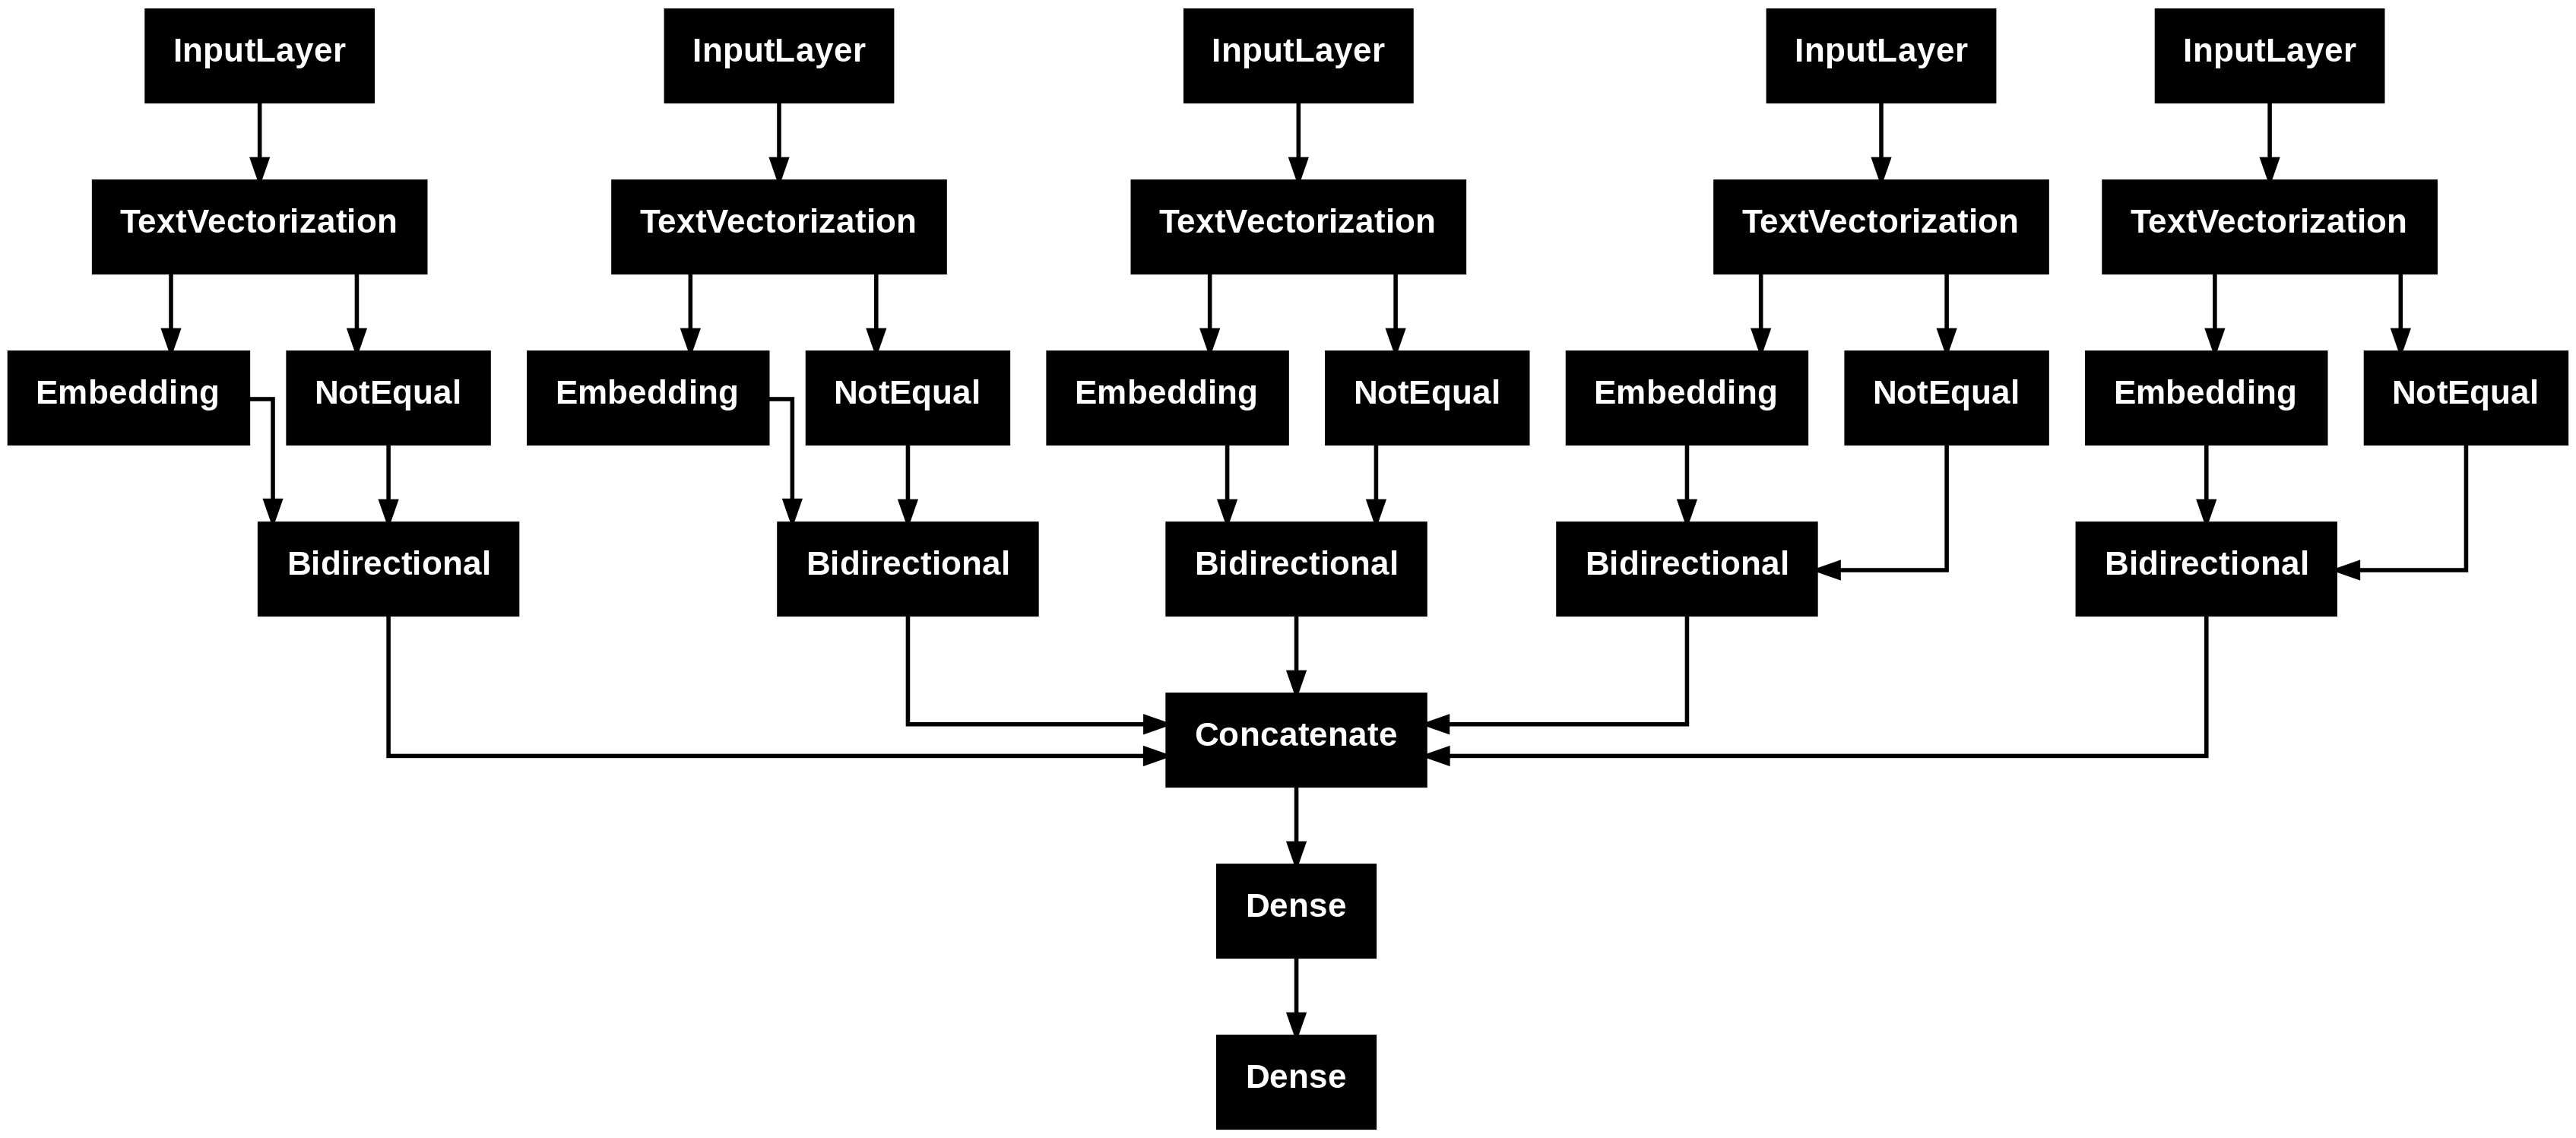

In [ ]:
keras.utils.plot_model(model_rnn)

Training the Text-Only Model

In [ ]:
# ... (previous code) ...

# Adapt the TextVectorization layers before using them
# Assuming 'text1', 'text2', 'text3', 'text4', 'text5' are your text data
# and 'vectorize1', 'vectorize2', 'vectorize3', 'vectorize4', 'vectorize5' are your TextVectorization layers

vectorize1.adapt(np.asarray(train_text1)) # Adapt vectorize1 to train_text1
vectorize2.adapt(np.asarray(train_text2)) # Adapt vectorize2 to train_text2
vectorize3.adapt(np.asarray(train_text3)) # Adapt vectorize3 to train_text3
vectorize4.adapt(np.asarray(train_text4)) # Adapt vectorize4 to train_text4
vectorize5.adapt(np.asarray(train_text5)) # Adapt vectorize5 to train_text5

# Now, you can use these layers to transform your text data
train_text1 = vectorize1(np.nan_to_num(train_text1, nan='').astype(str)).numpy().astype('int32')
train_text2 = vectorize2(np.nan_to_num(train_text2, nan='').astype(str)).numpy().astype('int32')
train_text3 = vectorize3(np.nan_to_num(train_text3, nan='').astype(str)).numpy().astype('int32')
train_text4 = vectorize4(np.nan_to_num(train_text4, nan='').astype(str)).numpy().astype('int32')
train_text5 = vectorize5(np.nan_to_num(train_text5, nan='').astype(str)).numpy().astype('int32')

val_text1 = vectorize1(np.nan_to_num(val_text1, nan='').astype(str)).numpy().astype('int32')
val_text2 = vectorize2(np.nan_to_num(val_text2, nan='').astype(str)).numpy().astype('int32')
val_text3 = vectorize3(np.nan_to_num(val_text3, nan='').astype(str)).numpy().astype('int32')
val_text4 = vectorize4(np.nan_to_num(val_text4, nan='').astype(str)).numpy().astype('int32')
val_text5 = vectorize5(np.nan_to_num(val_text5, nan='').astype(str)).numpy().astype('int32')

# Now you can fit the model with the numerical data
history = model_rnn.fit(
    [train_text1, train_text2, train_text3, train_text4, train_text5],
    train_labels,
    epochs=5,
    validation_data=([val_text1, val_text2, val_text3, val_text4, val_text5], val_labels)
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
history.history

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss (Text Only Data)')
plt.legend()
plt.show()


In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC (Text Only Data)')
plt.legend()
plt.show()


In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(fp) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives (Text Only Data)')
plt.legend()
plt.show()

In [ ]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(fn) + 1)
plt.figure()
plt.plot(epochs, fn, label='Training False Negatives')
plt.plot(epochs,  val_fn, label='Validation False Negatives')
plt.title('Training and validation False Negatives (Text Only Data)')
plt.legend()
plt.show()


Applying RNN on Test Set (Text-Only)

In [ ]:
all_text1=np.concatenate((train_text1, val_text1))
all_text2=np.concatenate((train_text2, val_text2))
all_text3=np.concatenate((train_text3, val_text3))
all_text4=np.concatenate((train_text4, val_text4))
all_text5=np.concatenate((train_text5, val_text5))

all_labels= np.concatenate((train_labels, val_labels))

model_rnn2 = build_text_rnn()
model_rnn2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)
print(model_rnn2.summary())

In [ ]:
history2 = model_rnn2.fit([all_text1, all_text2, all_text3, all_text4, all_text5], all_labels, epochs=5, validation_data=([test_text1, test_text2, test_text3, test_text4, test_text5], test_labels))


In [ ]:
history2.history


In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.figure()
plt.plot(epochs2, loss2, label='Training loss')
plt.plot(epochs2, val_loss2, label='Validation loss')
plt.title('Train+Validation and Testing loss (Text Only Data)')
plt.legend()
plt.show()

In [ ]:
auc2 = history2.history['auc']
val_auc2 = history2.history['val_auc']
epochs2 = range(1, len(auc2) + 1)
plt.figure()
plt.plot(epochs2, auc2, label='Training AUC')
plt.plot(epochs2, val_auc2, label='Validation AUC')
plt.title('Train+Validation and Testing AUC (Text Only Data)')
plt.legend()
plt.show()

In [ ]:
fp2 = history.history['fp']
val_fp2 = history.history['val_fp']
epochs = range(1, len(fp2) + 1)
plt.figure()
plt.plot(epochs, fp2, label='Training False Positives')
plt.plot(epochs, val_fp2, label='Validation False Positives')
plt.title('Training+Validation / Testing False Positives (Text Only Data)')
plt.legend()
plt.show()

In [ ]:
fn2 = history.history['fn']
val_fn2 = history.history['val_fn']
epochs = range(1, len(fn2) + 1)
plt.figure()
plt.plot(epochs, fn2, label='Training False Negatives')
plt.plot(epochs,  val_fn2, label='Validation False Negatives')
plt.title('Training+Validation / Testing False Negatives (Text Only Data)')
plt.legend()
plt.show()

Model with BERT

Installing Dependencies & Exploring BERT --

In [ ]:
#BERT dependencies
!pip install -q tensorflow-text
!pip install -q tf-models-official

In [ ]:

import tensorflow_hub as hub
import tensorflow_text as text # A dependency of the preprocessing model
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR') #filters out all messages

In [ ]:
# classic_bert_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4' #bert_en_uncased_L-12_H-768_A-12
small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2' ##considered small bert
# small_bert2_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2' #considered tiny bert

preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" #same preprocess layer for all bert models that I will use

# print('Classic BERT model selected            :', classic_bert_encoder)
print('Small BERT model selected           :', small_bert_encoder)
# print('Small BERT model #2 selected           :', small_bert2_encoder)
print('Preprocessing model auto-selected      :', preprocess_bert)


In [ ]:
text_test1 = [train_text1[0][:100]]


In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_bert)
text_preprocessed = bert_preprocess_model(text_test1)

print(f'Keys            : {list(text_preprocessed.keys())}')
print(f'Word Ids Shape  : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids        : {text_preprocessed["input_word_ids"][0, :30]}')
print(f'Input Mask Shape: {text_preprocessed["input_mask"].shape}')
print(f'Input Mask      : {text_preprocessed["input_mask"][0, :30]}')
print(f'Type Ids Shape  : {text_preprocessed["input_type_ids"].shape}')
print(f'Type Ids        : {text_preprocessed["input_type_ids"][0, :30]}')

In [ ]:
bert_encoders = [small_bert_encoder] #small_bert2_encoder, classic_bert_encoder

for be in bert_encoders:
  bert_model = hub.KerasLayer(be) #The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs
  bert_results = bert_model(text_preprocessed)

  print(f'Loaded BERT: {be}')
  print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}') #The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
  print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}') #For the fine-tuning you are going to use the pooled_output array
  print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
  print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}\n')


In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(preprocess_bert)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
#PREPROCESSING FOR BERT - TRAIN DATA
preproc_model1 = make_bert_preprocess_model(['title_loc_description'])
text = [train_text1]
preproc1 = preproc_model1(text)

preproc_model2 = make_bert_preprocess_model(['cat_vars'])
text = [train_text2]
preproc2 = preproc_model2(text)

preproc_model3 = make_bert_preprocess_model(['company_profile'])
text = [train_text3]
preproc3 = preproc_model3(text)

preproc_model4 = make_bert_preprocess_model(['requirements'])
text = [train_text4]
preproc4 = preproc_model4(text)

preproc_model5 = make_bert_preprocess_model(['benefits'])
text = [train_text5]
preproc5 = preproc_model5(text)

In [ ]:
print('preproc1 - training')
print('Keys           : ', list(preproc1.keys()))
print('Shape Word Ids : ', preproc1['input_word_ids'].shape)
print('Word Ids       : ', preproc1['input_word_ids'][0, :20])
print('Shape Mask     : ', preproc1['input_mask'].shape)
print('Input Mask     : ', preproc1['input_mask'][0, :20])
print('Shape Type Ids : ', preproc1['input_type_ids'].shape)
print('Type Ids       : ', preproc1['input_type_ids'][0, :20])

# print()
# print('preproc2 - training')
# print('Keys           : ', list(preproc2.keys()))
# print('Shape Word Ids : ', preproc2['input_word_ids'].shape)
# print('Word Ids       : ', preproc2['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc2['input_mask'].shape)
# print('Input Mask     : ', preproc2['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc2['input_type_ids'].shape)
# print('Type Ids       : ', preproc2['input_type_ids'][0, :16])

# print()
# print('preproc3 - training')
# print('Keys           : ', list(preproc3.keys()))
# print('Shape Word Ids : ', preproc3['input_word_ids'].shape)
# print('Word Ids       : ', preproc3['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc3['input_mask'].shape)
# print('Input Mask     : ', preproc3['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc3['input_type_ids'].shape)
# print('Type Ids       : ', preproc3['input_type_ids'][0, :16])

# print()
# print('preproc4 - training')
# print('Keys           : ', list(preproc4.keys()))
# print('Shape Word Ids : ', preproc4['input_word_ids'].shape)
# print('Word Ids       : ', preproc4['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc4['input_mask'].shape)
# print('Input Mask     : ', preproc4['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc4['input_type_ids'].shape)
# print('Type Ids       : ', preproc4['input_type_ids'][0, :16])

# print()
# print('preproc4 - training')
# print('Keys           : ', list(preproc4.keys()))
# print('Shape Word Ids : ', preproc4['input_word_ids'].shape)
# print('Word Ids       : ', preproc4['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc4['input_mask'].shape)
# print('Input Mask     : ', preproc4['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc4['input_type_ids'].shape)
# print('Type Ids       : ', preproc4['input_type_ids'][0, :16])

# print()
# print('preproc5 - training')
# print('Keys           : ', list(preproc5.keys()))
# print('Shape Word Ids : ', preproc5['input_word_ids'].shape)
# print('Word Ids       : ', preproc5['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc5['input_mask'].shape)
# print('Input Mask     : ', preproc5['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc5['input_type_ids'].shape)
# print('Type Ids       : ', preproc5['input_type_ids'][0, :16])



In [ ]:

tf.keras.utils.plot_model(preproc_model1)

In [ ]:
tf.keras.utils.plot_model(preproc_model2)

In [ ]:

tf.keras.utils.plot_model(preproc_model3)

In [ ]:

tf.keras.utils.plot_model(preproc_model4)

In [ ]:
tf.keras.utils.plot_model(preproc_model5)

In [ ]:
#PREPROCESSING FOR BERT - VAL DATA
val_texts=[val_text1, val_text2, val_text3, val_text4, val_text5]
val_preproc1 = preproc_model1([val_texts[0]]) #title_loc_description
val_preproc2 = preproc_model2([val_texts[1]]) #cat_vars
val_preproc3 = preproc_model3([val_texts[2]]) #company_profile
val_preproc4 = preproc_model4([val_texts[3]]) #requirements
val_preproc5 = preproc_model5([val_texts[4]]) #benefits

#PREPROCESSING FOR BERT - TEST DATA
test_texts=[test_text1, test_text2, test_text3, test_text4, test_text5]
test_preproc1 = preproc_model1([test_texts[0]]) #title_loc_description
test_preproc2 = preproc_model2([test_texts[1]]) #cat_vars
test_preproc3 = preproc_model3([test_texts[2]]) #company_profile
test_preproc4 = preproc_model4([test_texts[3]]) #requirements
test_preproc5 = preproc_model5([test_texts[4]]) #benefits

In [ ]:
def build_bert_model(encoder):
  inputs1 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids1'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask1'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids1')
    )
  encoder1 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder1')
  net1=encoder1(inputs1)['pooled_output']

  inputs2 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids2'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask2'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids2')
    )
  encoder2 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder2')
  net2=encoder2(inputs2)['pooled_output']

  inputs3 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids3'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask3'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids3')
    )
  encoder3 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder3')
  net3=encoder3(inputs3)['pooled_output']

  inputs4 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids4'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask4'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids4')
    )
  encoder4 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder4')
  net4=encoder4(inputs4)['pooled_output']

  inputs5 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids5'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask5'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids5')
    )
  encoder5 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder5')
  net5=encoder5(inputs5)['pooled_output']

  inputs = tf.keras.layers.concatenate([net1, net2, net3, net4, net5])
  x = tf.keras.layers.Dropout(0.1)(inputs)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
  return tf.keras.Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=[output])

In [ ]:
small_bert_model = build_bert_model(small_bert_encoder)
print(small_bert_model.summary())

In [ ]:
tf.keras.utils.plot_model(small_bert_model)


Fine-Tuning BERT Model --

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics_list = [
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
  ]

metrics = metrics_list


In [ ]:
epochs = 1
steps_per_epoch = len(train_t)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [ ]:

print(steps_per_epoch)
print(num_train_steps)
print(num_warmup_steps)

Small BERT model (small_bert/bert_en_uncased_L-4_H-512_A-4)

In [ ]:
small_bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#training model with small bert
history = small_bert_model.fit([preproc1, preproc2, preproc3, preproc4, preproc5], train_labels, epochs=1, validation_data=([val_preproc1, val_preproc2, val_preproc3, val_preproc4, val_preproc5], val_labels))


In [ ]:

history.history


Classic BERT model (bert_en_uncased_L-12_H-768_A-12) --> CANNOT RUN ON COLAB CPU

In [ ]:
# bert_model = build_bert_model(classic_bert_encoder)
# print(bert_model.summary())


In [ ]:
# bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# history.history



Applying the Small-BERT model to the testing set

In [ ]:
small_bert_model.evaluate([test_preproc1, test_preproc2, test_preproc3, test_preproc4, test_preproc5], test_labels)
